#**Introduction**

### **Contextualisation**

Les médias écrits et audiovisuels sont un maillon essentiel du pluralisme politique. Leur
numérisation et l’explosion des contenus informationnels en ligne favorisent a priori la
formation d’opinions plurielles, garantes d’un bon fonctionnement de la démocratie. Pour
autant, ce pluralisme des contenus et des sources n’est pas synonyme en soi de qualité de
l’information. C’est à ces questions de pluralisme et de qualité de l’information en ligne que
s’intéressent les chercheurs du projet national PIL (http://www.anr-pil.org/) démarré en
2018.

En tant que réseau social en ligne, Youtube constitue un espace public de partage
d’information et d’interactions entre utilisateurs, aussi bien propice à la co-création de
valeur qu’au développement de comportements toxiques, de propagande politique voire de
contenus radicalisés. C’est dans ce contexte que les chercheurs de l’ANR PIL ont extrait une
grande base de données de vidéos Youtube issues de 58 chaines de medias français, qui est
mise à disposition pour votre challenge.

###**But du Challenge**

L’objectif de ce challenge est de comprendre et prédire la notion de toxicité dans une vidéo
Youtube. Il s’agit de déterminer dans quelle mesure l’espace des commentaires des médias
français est touché par les débats brutaux et agressifs. Nous posons comme objectif de
comprendre où et quand l’agressivité en ligne est retrouvée et quels facteurs la limitent et la
favorisent. 

D’abord, en abordant la question sous la forme d’un problème de régression
visant à prédire le nombre d’insultes présentes dans les commentaires associés à une
vidéo. 

Ensuite, en construisant puis prédisant un indice original de toxicité à partir des
variables présentes dans la base.

#**Imports des différentes librairies**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn 
import time
import random
import tensorflow as tf
import sklearn.metrics as metrics
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor ,KNeighborsClassifier
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR
from warnings import filterwarnings
from tensorflow.data import Dataset
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Reshape, Softmax
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import Mean, MeanAbsoluteError
from tensorflow.keras import Model
from sklearn.linear_model import LinearRegression

#**Chargement du fichier**

In [ ]:
df_youtube = pd.DataFrame(pd.read_csv('/content/challenge_2_youtube_toxic.csv',encoding='iso-8859-1',  delimiter=";",error_bad_lines=False ))
df_youtube

,video_id_court,video_id,channel_id,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,channel_name,subscriberCount,viewCount,categorie_new,categ_inst
0,Uvvsvw_wxOs,VVU5R0d6QWhodmhKTzFoTDEwLUJjZ05BLlV2dnN2d193eE9z,UC9GGzAhhvhJO1hL10-BcgNA,3813,18,4,145,79,60,"30,2619","0,1428571","0,03174603","1,150794","0,6269841","0,4761905",45,81,126,28,58,47,23,LeHuffPost,339922,225393312,Core,Pure Players
1,mCy1ZBdttwA,VVVYS0pyWWN6WTJfZkpFWmdGUEdZMEhRLm1DeTFaQmR0dHdB,UCXKJrYczY2_fJEZgFPGY0HQ,28,2,0,1,0,0,"9,333333","0,6666667",0,"0,3333333",0,0,3,0,3,0,3,1,0,CNEWS,189971,132125693,Core,TV
2,iU3MyHMK5nU,VVU5R0d6QWhodmhKTzFoTDEwLUJjZ05BLmlVM015SE1LNW5V,UC9GGzAhhvhJO1hL10-BcgNA,3804,68,9,56,75,54,"27,56522","0,4927536","0,06521739","0,4057971","0,5434783","0,3913043",52,86,138,22,83,49,36,LeHuffPost,339922,225393312,Core,Pure Players
3,ZUim3AeURtk,VVViWjBDc3I5b3c2WGprZGQ1NDJPbWh3LlpVaW0zQWVVUnRr,UCbZ0Csr9ow6Xjkdd542Omhw,4,0,1,2,0,0,2,0,"0,5",1,0,0,2,0,2,0,2,0,0,Telegramme,2862,2481100,Niche,Presse_regionale
4,n5Tg2vhLCAM,VVVoWldzNlBKWTBoTkQzODRkMl9ScmhRLm41VGcydmhMQ0FN,UChZWs6PJY0hND384d2_RrhQ,737,3,1,18,5,6,"32,04347826","0,130434783","0,043478261","0,782608696","0,217391304","0,260869565",17,6,23,4,18,7,7,Les Echos,30010,6710737,Core,Presse nationale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46097,0s_hwJrt_6E,VVVmSG5fOC1laGRlbTg2ZkV2bEZnLUd3LjBzX2h3SnJ0XzZF,UCfHn_8-ehdem86fEvlFg-Gw,16,0,0,0,3,0,"5,333333333",0,0,0,1,0,3,0,3,0,3,1,0,Le Parisien,149018,85536183,Core,Presse_regionale
46098,ktsFSiFN1VY,VVVZcFJEbmhrNUg4aDE2anBTODR1cXNBLmt0c0ZTaUZOMVZZ,UCYpRDnhk5H8h16jpS84uqsA,228,1,1,0,0,1,228,1,1,0,0,1,1,0,1,0,1,0,0,Le Monde,568615,134570352,Core,Presse nationale
46099,#NOM?,VVVYS0pyWWN6WTJfZkpFWmdGUEdZMEhRLi1abDVDaUtkZkFz,UCXKJrYczY2_fJEZgFPGY0HQ,287,2,0,3,2,0,"35,875","0,25",0,"0,375","0,25",0,8,0,8,0,7,5,3,CNEWS,189971,132125693,Core,TV
46100,CyHXcpFlrTg,VVVDRHpfWFllS1dkME9JeWpwOTVkcXlRLkN5SFhjcEZsclRn,UCCDz_XYeKWd0OIyjp95dqyQ,176,0,0,0,6,3,"58,66667",0,0,0,2,1,2,1,3,1,3,0,1,Le Figaro,180173,140135417,Core,Presse nationale


In [ ]:
# Certaines variables sont censées être des nombres mais ne le sont pas. 
# Il faut convertir les points en virgule et changer le type. C'est ce que nous faisons ici. 
df_youtube['nbrMotMoyenne'] = [x.replace(',', '.') for x in df_youtube['nbrMotMoyenne']]
df_youtube['nbrMotInsulteMoyenne'] = [x.replace(',', '.') for x in df_youtube['nbrMotInsulteMoyenne']]
df_youtube['nbrMotAllongMoyenne'] = [x.replace(',', '.') for x in df_youtube['nbrMotAllongMoyenne']]
df_youtube['nbrMotMAJMoyenne'] = [x.replace(',', '.') for x in df_youtube['nbrMotMAJMoyenne']]
df_youtube['nbrExclMarkMoyenne'] = [x.replace(',', '.') for x in df_youtube['nbrExclMarkMoyenne']]
df_youtube['nbrQuestMarkMoyenne'] = [x.replace(',', '.') for x in df_youtube['nbrQuestMarkMoyenne']]

df_youtube['nbrMotMoyenne'] = df_youtube['nbrMotMoyenne'].astype(float)
df_youtube['nbrMotInsulteMoyenne'] = df_youtube['nbrMotInsulteMoyenne'].astype(float)
df_youtube['nbrMotAllongMoyenne'] = df_youtube['nbrMotAllongMoyenne'].astype(float)
df_youtube['nbrMotMAJMoyenne'] = df_youtube['nbrMotMAJMoyenne'].astype(float)
df_youtube['nbrExclMarkMoyenne'] = df_youtube['nbrExclMarkMoyenne'].astype(float)
df_youtube['nbrQuestMarkMoyenne'] = df_youtube['nbrQuestMarkMoyenne'].astype(float)
df_youtube = df_youtube.drop(labels=['Unnamed: 27'],axis=1).copy()

KeyError: ignored

#**Analyses Statistiques**

## **Analyses préalables**

In [ ]:
# Commençons par décrire rapidement le dataframe avec quelques statistiques
df_youtube.describe()

,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,subscriberCount,viewCount
count,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,46102.000000,4.610200e+04
mean,1435.853564,9.418225,3.974665,21.922823,21.823066,13.591276,25.264768,0.189175,0.080849,0.583485,0.633837,0.276134,22.219145,25.700816,47.919960,5.040085,28.726021,14.502646,10.974036,172108.752744,9.255061e+07
std,7670.789422,61.616732,21.367879,130.038591,120.607203,68.803038,31.979351,0.444356,0.305948,3.114312,1.600474,0.950349,117.441322,130.742237,234.791106,19.578795,140.334032,56.251117,50.607716,119508.318824,6.778302e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.109100e+04
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.769231,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,87793.000000,4.635634e+07
50%,72.000000,0.000000,0.000000,0.000000,1.000000,1.000000,18.630032,0.000000,0.000000,0.000000,0.250000,0.040161,3.000000,0.000000,4.000000,0.000000,3.000000,2.000000,1.000000,180173.000000,6.388093e+07
75%,398.000000,3.000000,1.000000,6.000000,9.000000,4.000000,31.000000,0.222222,0.068821,0.400000,0.750000,0.333333,9.000000,5.000000,16.000000,2.000000,11.000000,7.000000,4.000000,217835.000000,1.321257e+08
max,662808.000000,7227.000000,1416.000000,14270.000000,11093.000000,5520.000000,1349.500000,14.000000,28.000000,162.000000,104.000000,120.750000,8734.000000,11195.000000,19336.000000,1235.000000,9837.000000,3762.000000,3732.000000,568615.000000,2.414350e+08


Cette courte description nous sera sans aucun doute **utile pour la phase de feature engineering**. Elle nous permet aussi de nous faire une **analyse statistique détaillée**. Elle constitue une bonne base pour la suite. 

In [ ]:
# Regardons rapidmement le nombre de lignes et de colonnes du set de données, cela nous sera utile pour d'éventuelles vérifications
print("Nombre de lignes :",len(df_youtube.index),"\nNombre de colonnes :",len(df_youtube.columns))

Nombre de lignes : 46102 
Nombre de colonnes : 27


Nous avons maintenant récupéré le nombre de lignes et de colonnes, cela nous sera utile, sans aucun doute pour des vérifications. 

In [ ]:
# Afin d'éviter d'éventuels problèmes, vérifions qu'il n'y a pas de données manquantes
print ("Valeur(s) Manquante(s) :", df_youtube.isnull().sum().values.sum())

Valeur(s) Manquante(s) : 0


Maintenant que nous avons vérifié ce point, nous allons pouvoir commencer à **décrire le dataset et à émettre certaines hypothèses à l'aide de graphiques**. 

## **Analyses graphiques**

#### **Donut Plot : Visualiser les Insultes**

Nous allons commencer par regarder quel pourcentage représente les insultes dans le total des mots. 

##### *Graphique*

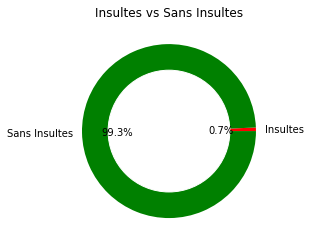

<Figure size 432x288 with 0 Axes>

In [ ]:
# Préparons la donnée
somme_nbr_mot = sum(df_youtube.nbrMot)
somme_nbr_mot_insulte = sum(df_youtube.nbrMotInsulte)
somme_sans_insulte = somme_nbr_mot-somme_nbr_mot_insulte

# Créons le graphique ! 
size = [somme_nbr_mot_insulte, somme_sans_insulte]
names = "Insultes","Sans Insultes"
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['red','green'],autopct="%.1f%%")
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Insultes vs Sans Insultes")
plt.figure()
plt.rc('figure', figsize=[10, 10])

#####*Conclusion générale :* 

Les insultes représentent seulement **0,7% du total des mots**.

#### **Box-Plot**

La grande quantité de données rend la **visualisation des données au travers d'une box-plot unique impossible**. Nous allons proposer des **box plots par groupe** : groupe Nbr, groupe NbrMoyenne et groupe Count (ces groupes ont été déterminé à l'aide des encodages ajoutés à la fin de chaque feature). 

Afin de **rendre la lecture des box plots plus facile, nous allons standardiser (centrer et réduire les données)**. Le résultat de l'analyse restera le même. Cependant, des valeurs inférieures à 0 peuvent appraitre du fait de valeurs inférieures à la moyenne. Cette précision est faite car dans le dataset, il n'y a pas de valeurs négatives. 

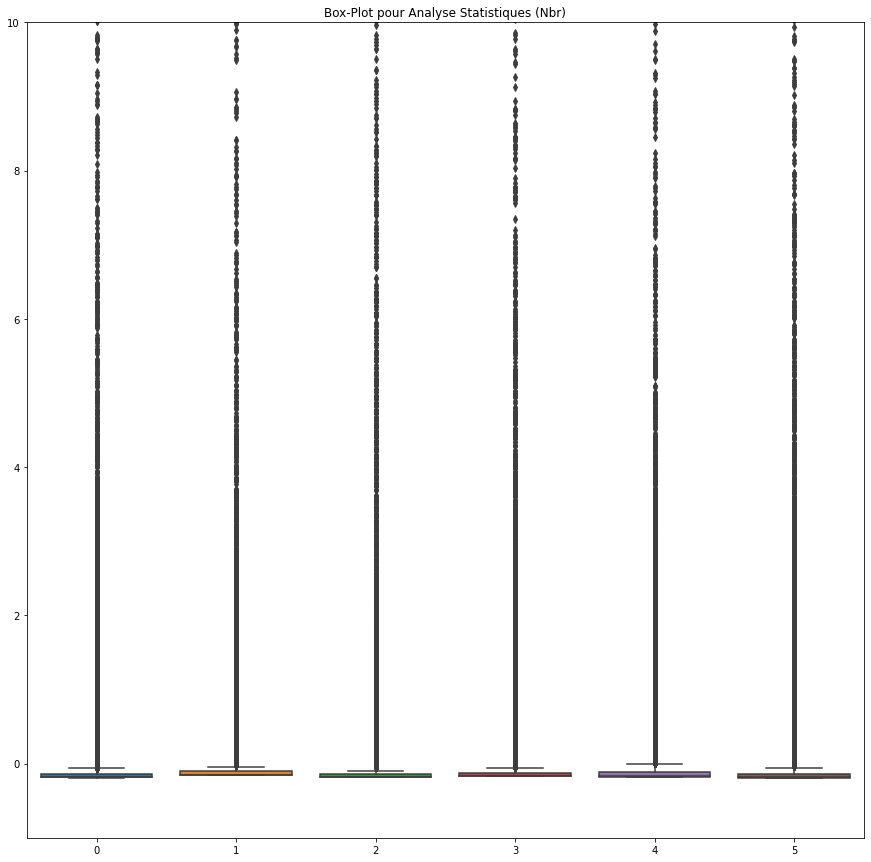

<Figure size 1080x1080 with 0 Axes>

In [ ]:
# Commençons par présenter le groupe Nbr

# Créons le dataframe lié à ce groupe
df_box_plot = df_youtube.drop(["video_id_court","video_id","channel_id","channel_name","categorie_new","categ_inst"], axis = 1).copy()
stds = preprocessing.StandardScaler()
df_box_plot_nbr = df_box_plot.drop(["nbrMotMoyenne","nbrMotInsulteMoyenne","nbrMotAllongMoyenne","nbrMotMAJMoyenne","nbrExclMarkMoyenne","nbrQuestMarkMoyenne","thread_count","comment_count","message_count","discussion_count","distinct_authors_count","authors_3channels_count","liked_authors_count","subscriberCount","viewCount"], axis = 1).copy()
df_box_plot_nbr = stds.fit_transform(df_box_plot_nbr)

# Maintenant, nous pouvons réaliser la première box-plot
sns.boxplot(data = df_box_plot_nbr)
plt.title ("Box-Plot pour Analyse Statistiques (Nbr)")
axes = plt.gca()
axes.set_ylim(-1, 10)
plt.figure()
plt.rc('figure', figsize=[15, 15])

(-1.0, 10.0)

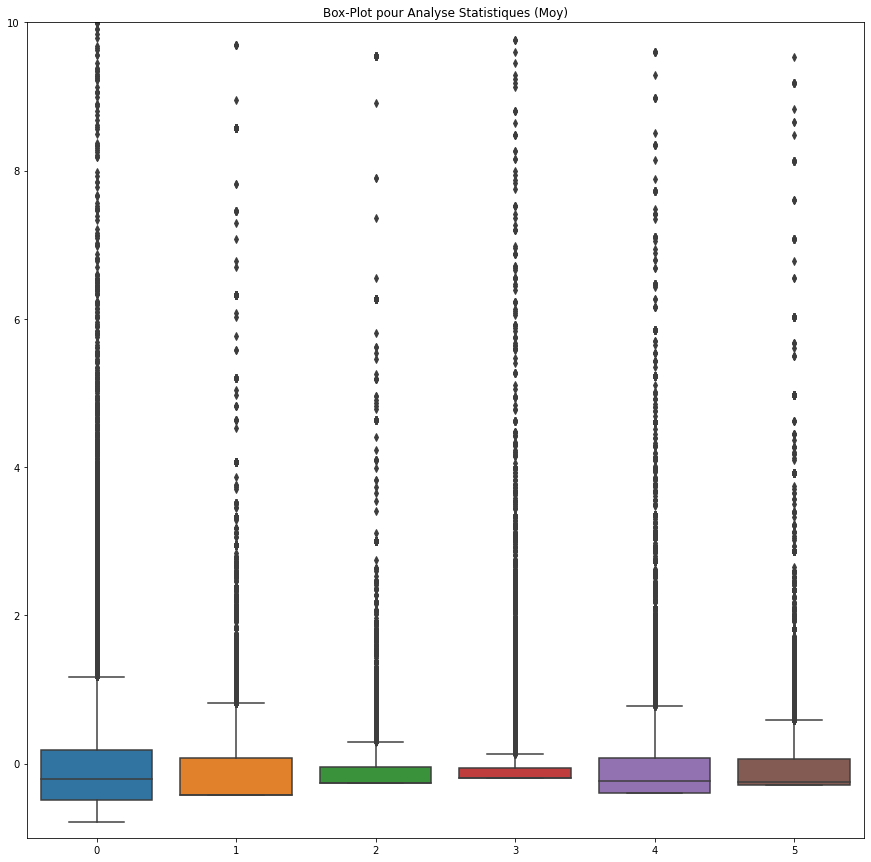

In [ ]:
# Continuons avec le groupe NbrMoyenne, la même méthodologie sera appliquée 
df_box_plot_moy = df_box_plot.drop(["nbrMot","nbrMotInsulte","nbrMotAllong","nbrMotMAJ","nbrExclMark","nbrQuestMark","thread_count","comment_count","message_count","discussion_count","distinct_authors_count","authors_3channels_count","liked_authors_count","subscriberCount","viewCount"], axis = 1).copy()
df_box_plot_moy = stds.fit_transform(df_box_plot_moy)
sns.boxplot(data = df_box_plot_moy)
plt.title ("Box-Plot pour Analyse Statistiques (Moy)")
axes = plt.gca()
axes.set_ylim(-1, 10)

(-2.0, 10.0)

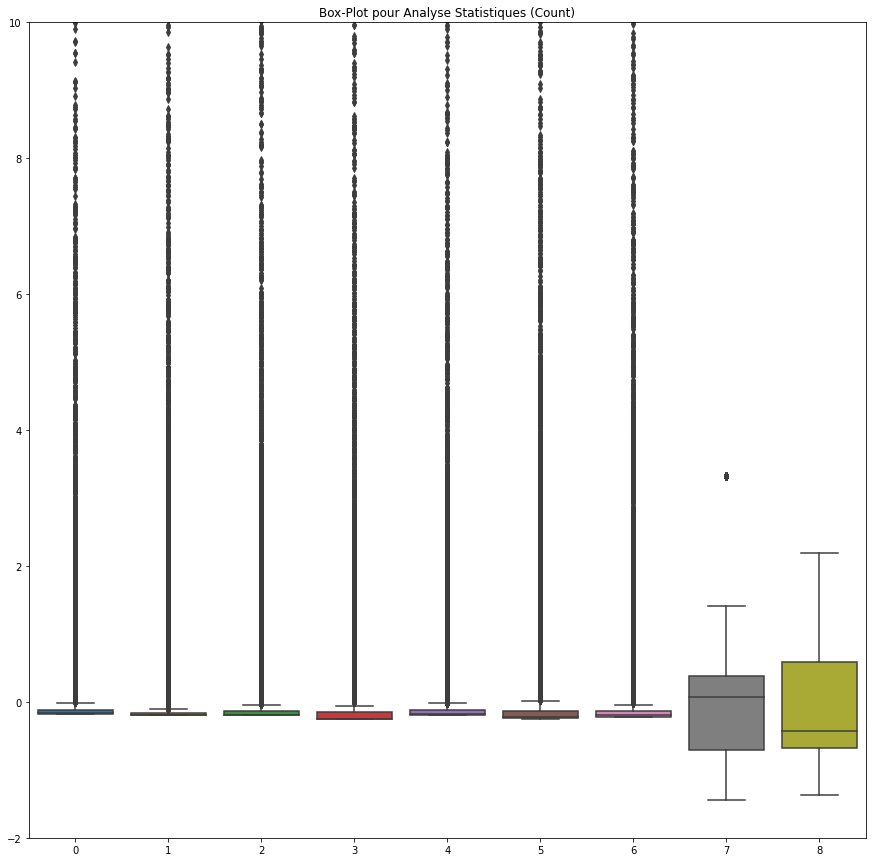

In [ ]:
# Terminons avec le groupe Count
df_box_plot_count = df_box_plot.drop(["nbrMot","nbrMotInsulte","nbrMotAllong","nbrMotMAJ","nbrExclMark","nbrQuestMark","nbrMotMoyenne","nbrMotInsulteMoyenne","nbrMotAllongMoyenne","nbrMotMAJMoyenne","nbrExclMarkMoyenne","nbrQuestMarkMoyenne"], axis = 1).copy()
df_box_plot_count = stds.fit_transform(df_box_plot_count)
sns.boxplot(data = df_box_plot_count)
plt.title ("Box-Plot pour Analyse Statistiques (Count)")
axes = plt.gca()
axes.set_ylim(-2, 10)

**Conclusion Box-Plot :** Nous pouvons remarquer de **nombreuses valeurs extrêmes dans toutes les box-plots** que nous avons réalisé. Cela ne parait **pas aberrant car une vidéo devennant "virale" provoque énormément de commentaire, de réactions, de vues, etc**. Toutes les vidéos du dataset ne sont pas des vidéos virales. 

L'analyse avec les box-plots ne nous permet pas réellement d'émettre des hypothèses ou d'analyser autre chose que les valeurs extrêmes, qui **seront peut être à éliminer.**

#### **Analyses par Chaine**

Nous allons maintenant entrer dans l'**analyse pure qui servira à faire émerger des hypothèses ou à mieux comprendre la donnée**. 

Nous allons commencer par une **analyse par chaine (channel)**. 

##### *Analyses Générales par chaines*

Nous allons commencer par **analyser globalement les chaines** à l'aide de graphiques. 

In [ ]:
# Commençons par créer un dataframe par chaine qui sera utilisé pour nos analyses
df_channel = df_youtube.groupby(["channel_name"]).agg({"nbrMot":"sum","nbrMotInsulte":"sum","video_id":"count","viewCount":"sum","subscriberCount":"mean"}).reset_index()


Text(0.5, 0, '# Vidéos')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


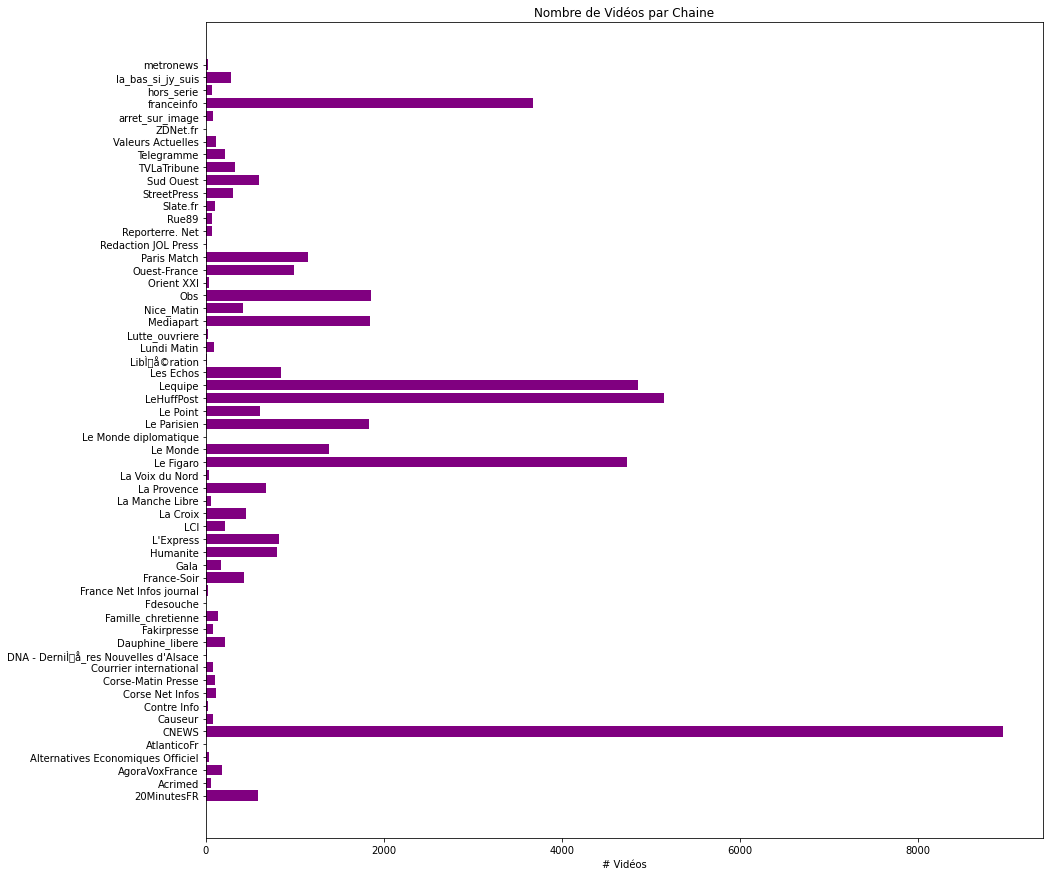

In [ ]:
# Regardons le nombre de vidéos par chaine
plt.title("Nombre de Vidéos par Chaine")
plt.barh(df_channel.channel_name,df_channel.video_id, color = 'purple')
plt.xlabel("# Vidéos")

**Conclusion intermédiaire :** Nous remarquons que les "pure players" (média uniquement en ligne) comme le Huff Post ont tendance à publier plus de vidéos sur leurs chaines YouTube.

Mais le record de vidéos sur une chaine YouTube est pour CNews. Cela semble logique car **CNews est une chaine de télévision d'informations**. 

Des **médias plus tradionnels** comme Le Parisien, L'Equipe ou encore Le Figaro publient eux-aussi un **grand nombre de vidéos sur YouTube**. 

Il est **maintenant intéressant d'analyser le nombre de vue par chaine et de voir si les médias précédemment cités sont toujours en tête**. 

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


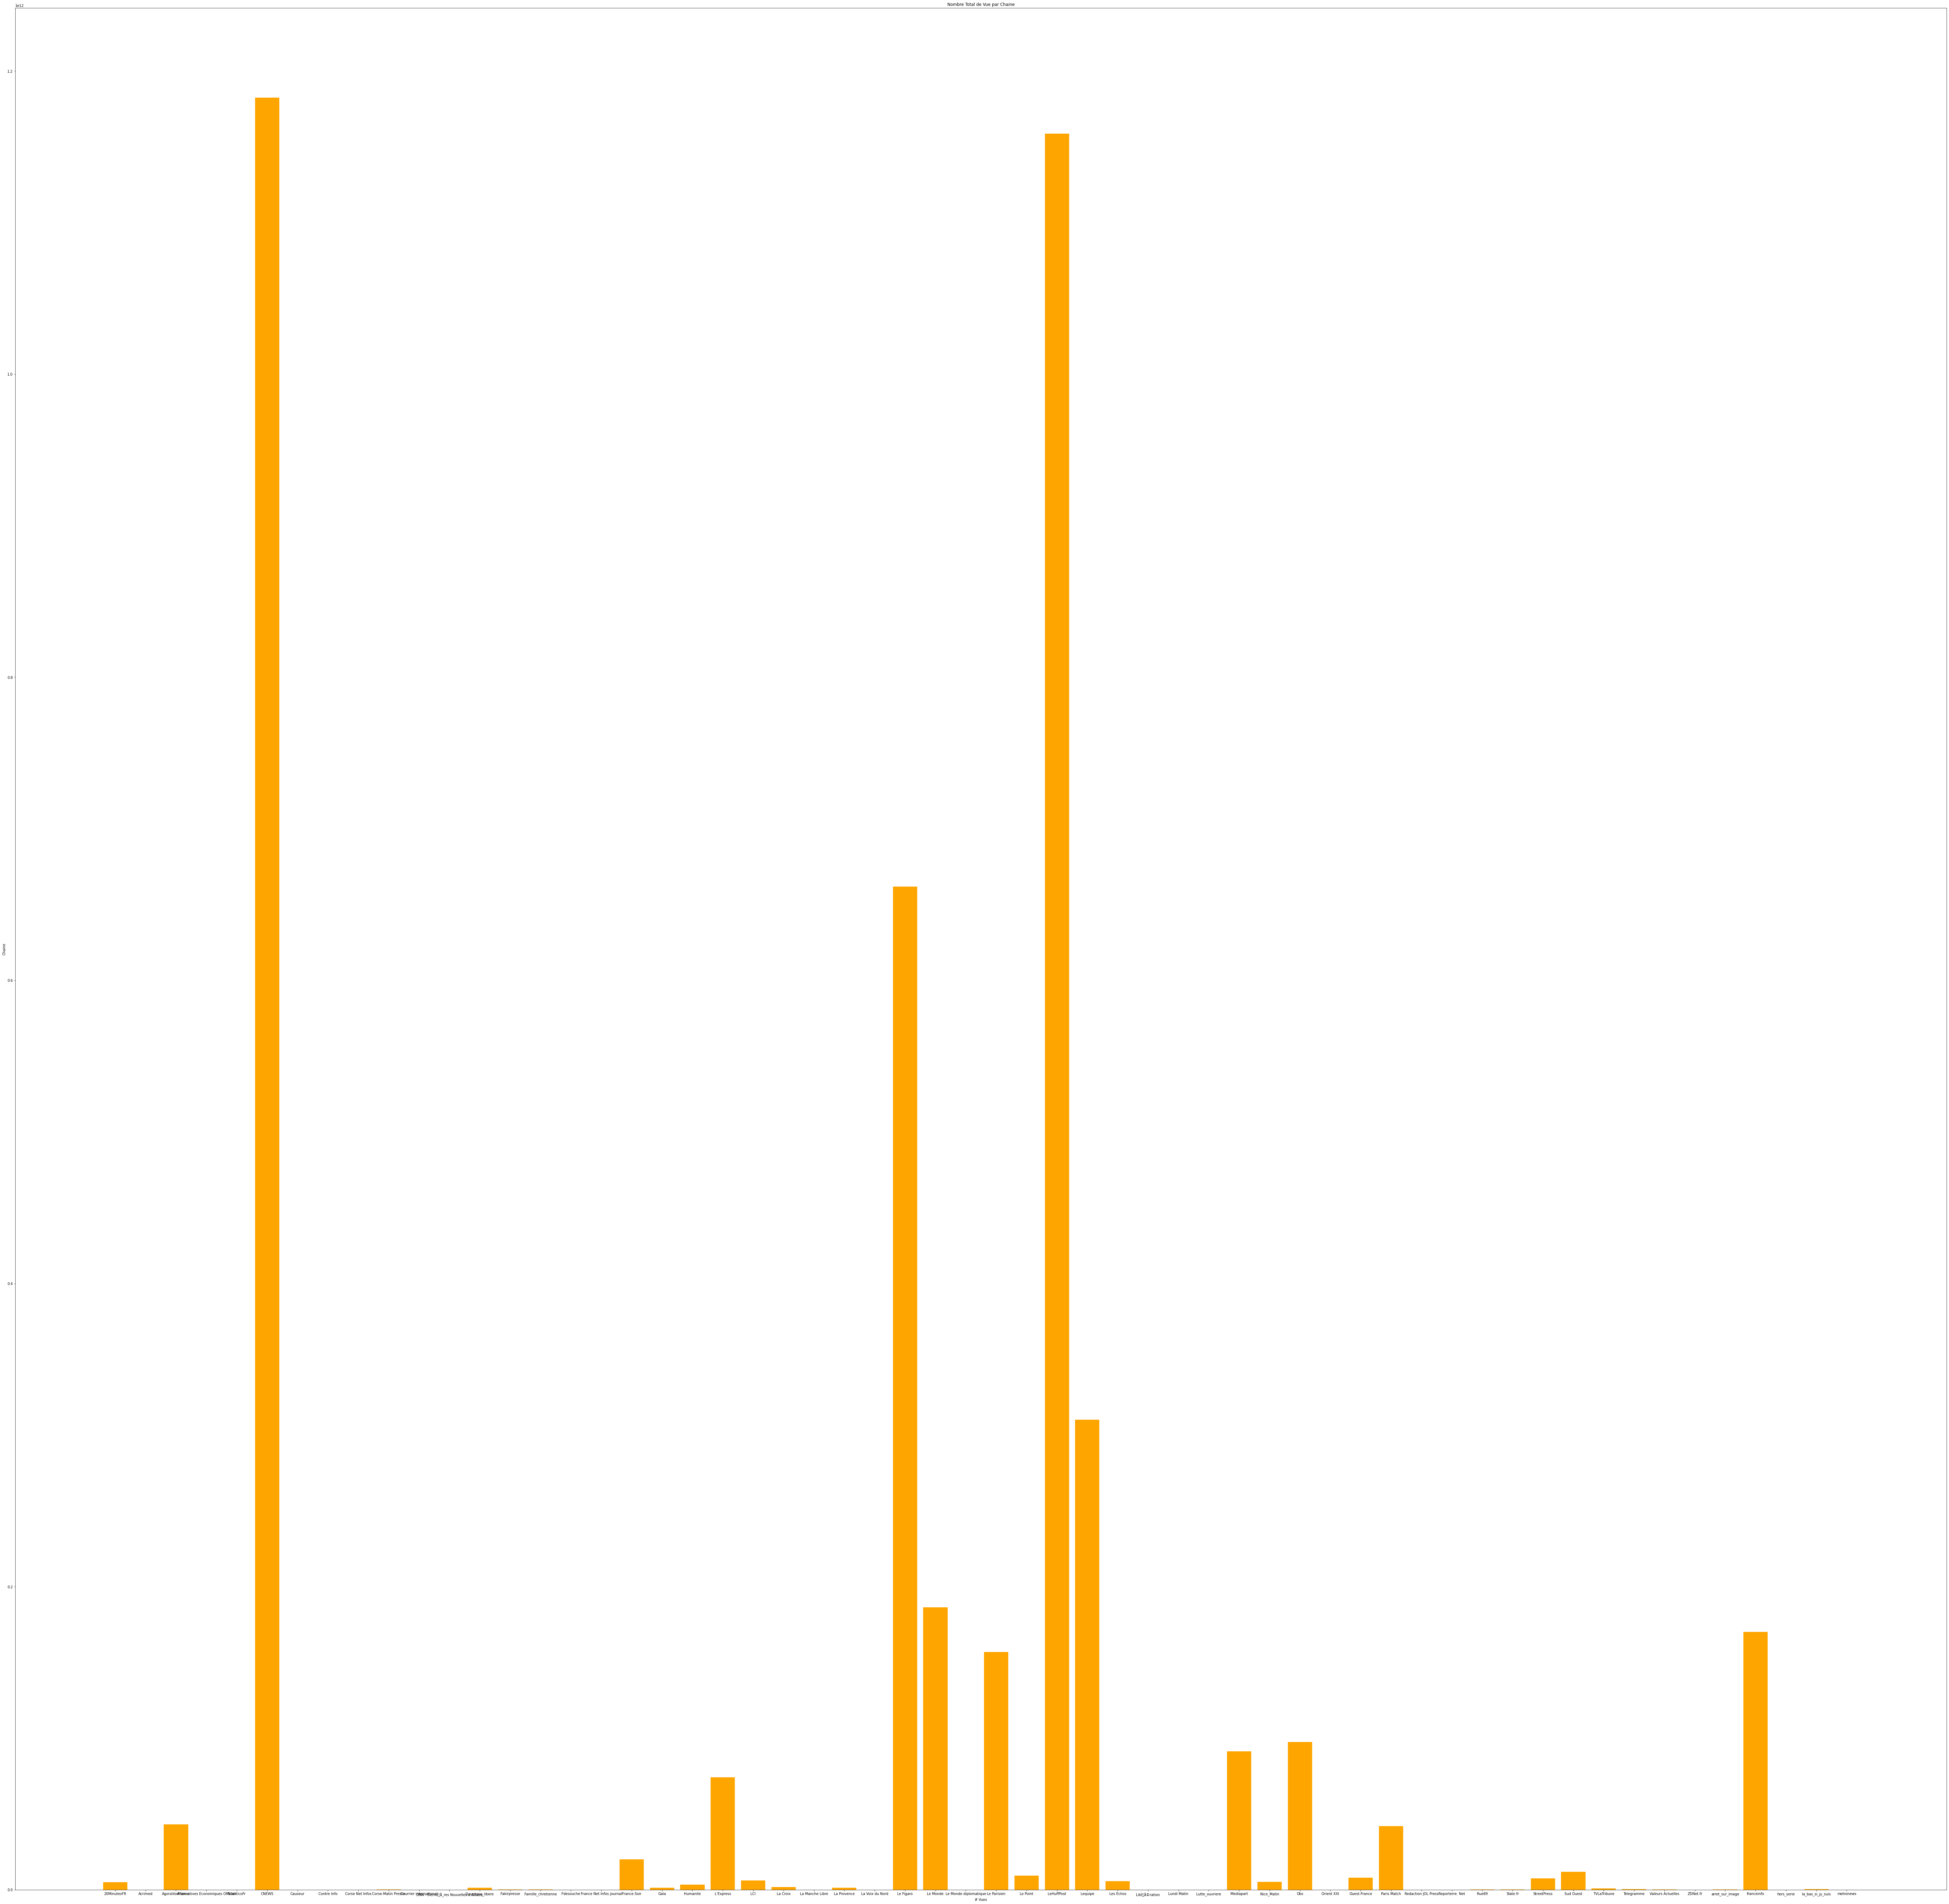

<Figure size 7200x7200 with 0 Axes>

In [ ]:
# Analysons maintenant le nombre de vues par chaine 
plt.title("Nombre Total de Vue par Chaine")
plt.xlabel("# Vues")
plt.ylabel("Chaine")
plt.bar(df_channel.channel_name,df_channel.viewCount, color = 'orange')
plt.figure()
plt.rc('figure', figsize=[100, 100])

**Conclusion intermédiaire :** Les **médias faisant le plus de vues sont les mêmes médias (ou presque) que ceux ayant le plus de vidéos en ligne**. Cela semble logique mais cette vérification s'imposait cat on pouvait penser que certaines chaines arrivaient à **réaliser beaucoup de vue avec peu de vidéos**. 

Pour mieux analyser ce phénomène, il faut se pencher sur le **nombre de vue moyen par vidéo**. 

<BarContainer object of 58 artists>

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


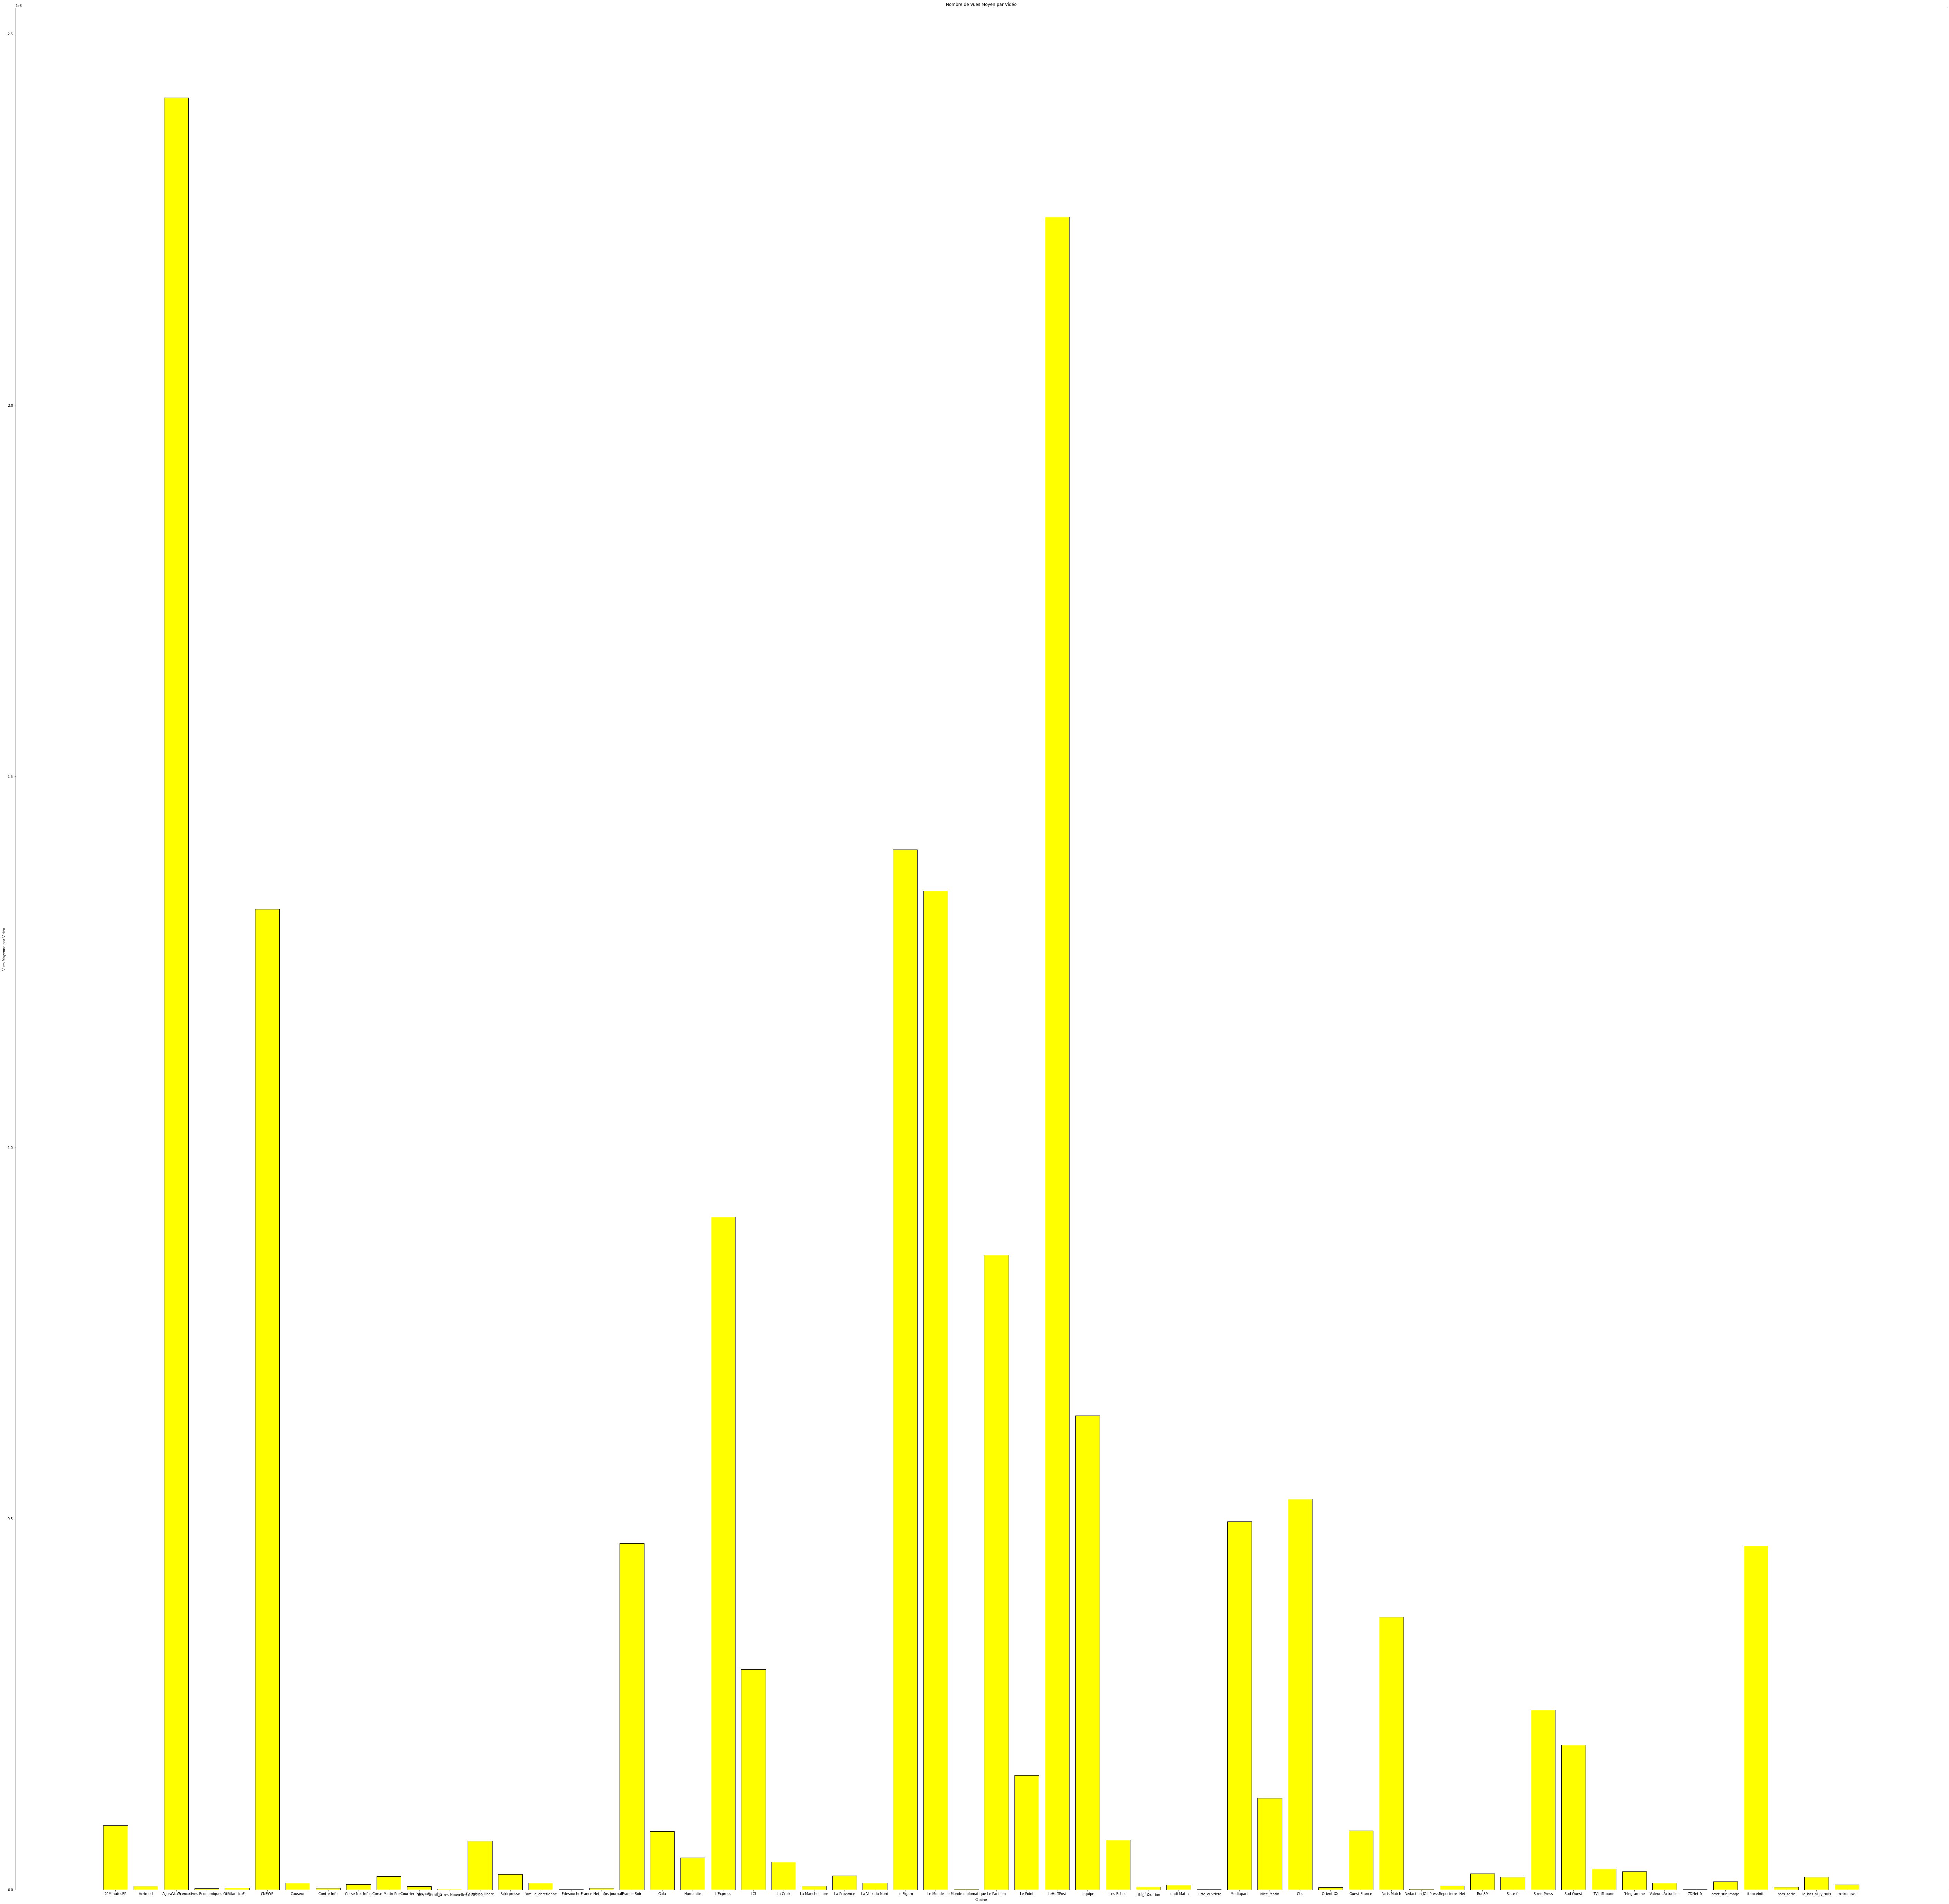

In [ ]:
# Déterminons le nombre de vue moyen par vidéo. Pour cela, ajoutons une colonne au dataframe df_channel
def vue_video(df):
  result = 0
  if df.video_id != 0:
    result = df.viewCount/df.video_id
  return result 
df_channel["Ratio_Vue"]=df_channel.apply(lambda row : vue_video(row), axis = 1)

# Traçons le graphique et concluons cette partie
plt.title("Nombre de Vues Moyen par Vidéo")
plt.xlabel("Chaine")
plt.ylabel("Vues Moyenne par Vidéo")
plt.bar(df_channel.channel_name,df_channel.Ratio_Vue,color = 'yellow', edgecolor = "black")

**Conclusion intermédiaire :** Les résultats obtenus ne sont pas les mêmes que pour les deux analyses précédentes. En effet, **le média réalisant le plus grand de vue par vidéo est AgoraVox**, un média complotiste. 

**L'Equipe média sportif arrive en seconde position. Ce résultat est logique car globalement, le sport se regarde plus qu'il ne se lit**. 

Les **médias traditionnels** nationaux que sont le Figaro et Le Monde sont eux aussi **bien placés**. 

Les **pure players** comme le Huffington Post (Huff Post) n'arrivent **pas aussi bien placé que l'on pourrait le penser**. 

Il faut maintenant se tourner vers une analyse plus appronfie. Cette dernière ne devra pas seulement être descriptive mais devra aussi apporter de l'information. **Nous allons analyser le lien potentiel entre le NbrMotInsulte (variable à prévoir) et le channelName**. 

##### *Analyses du Nombre de Mots d'Insulte par Chaine*

Text(0, 0.5, '# Insultes')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


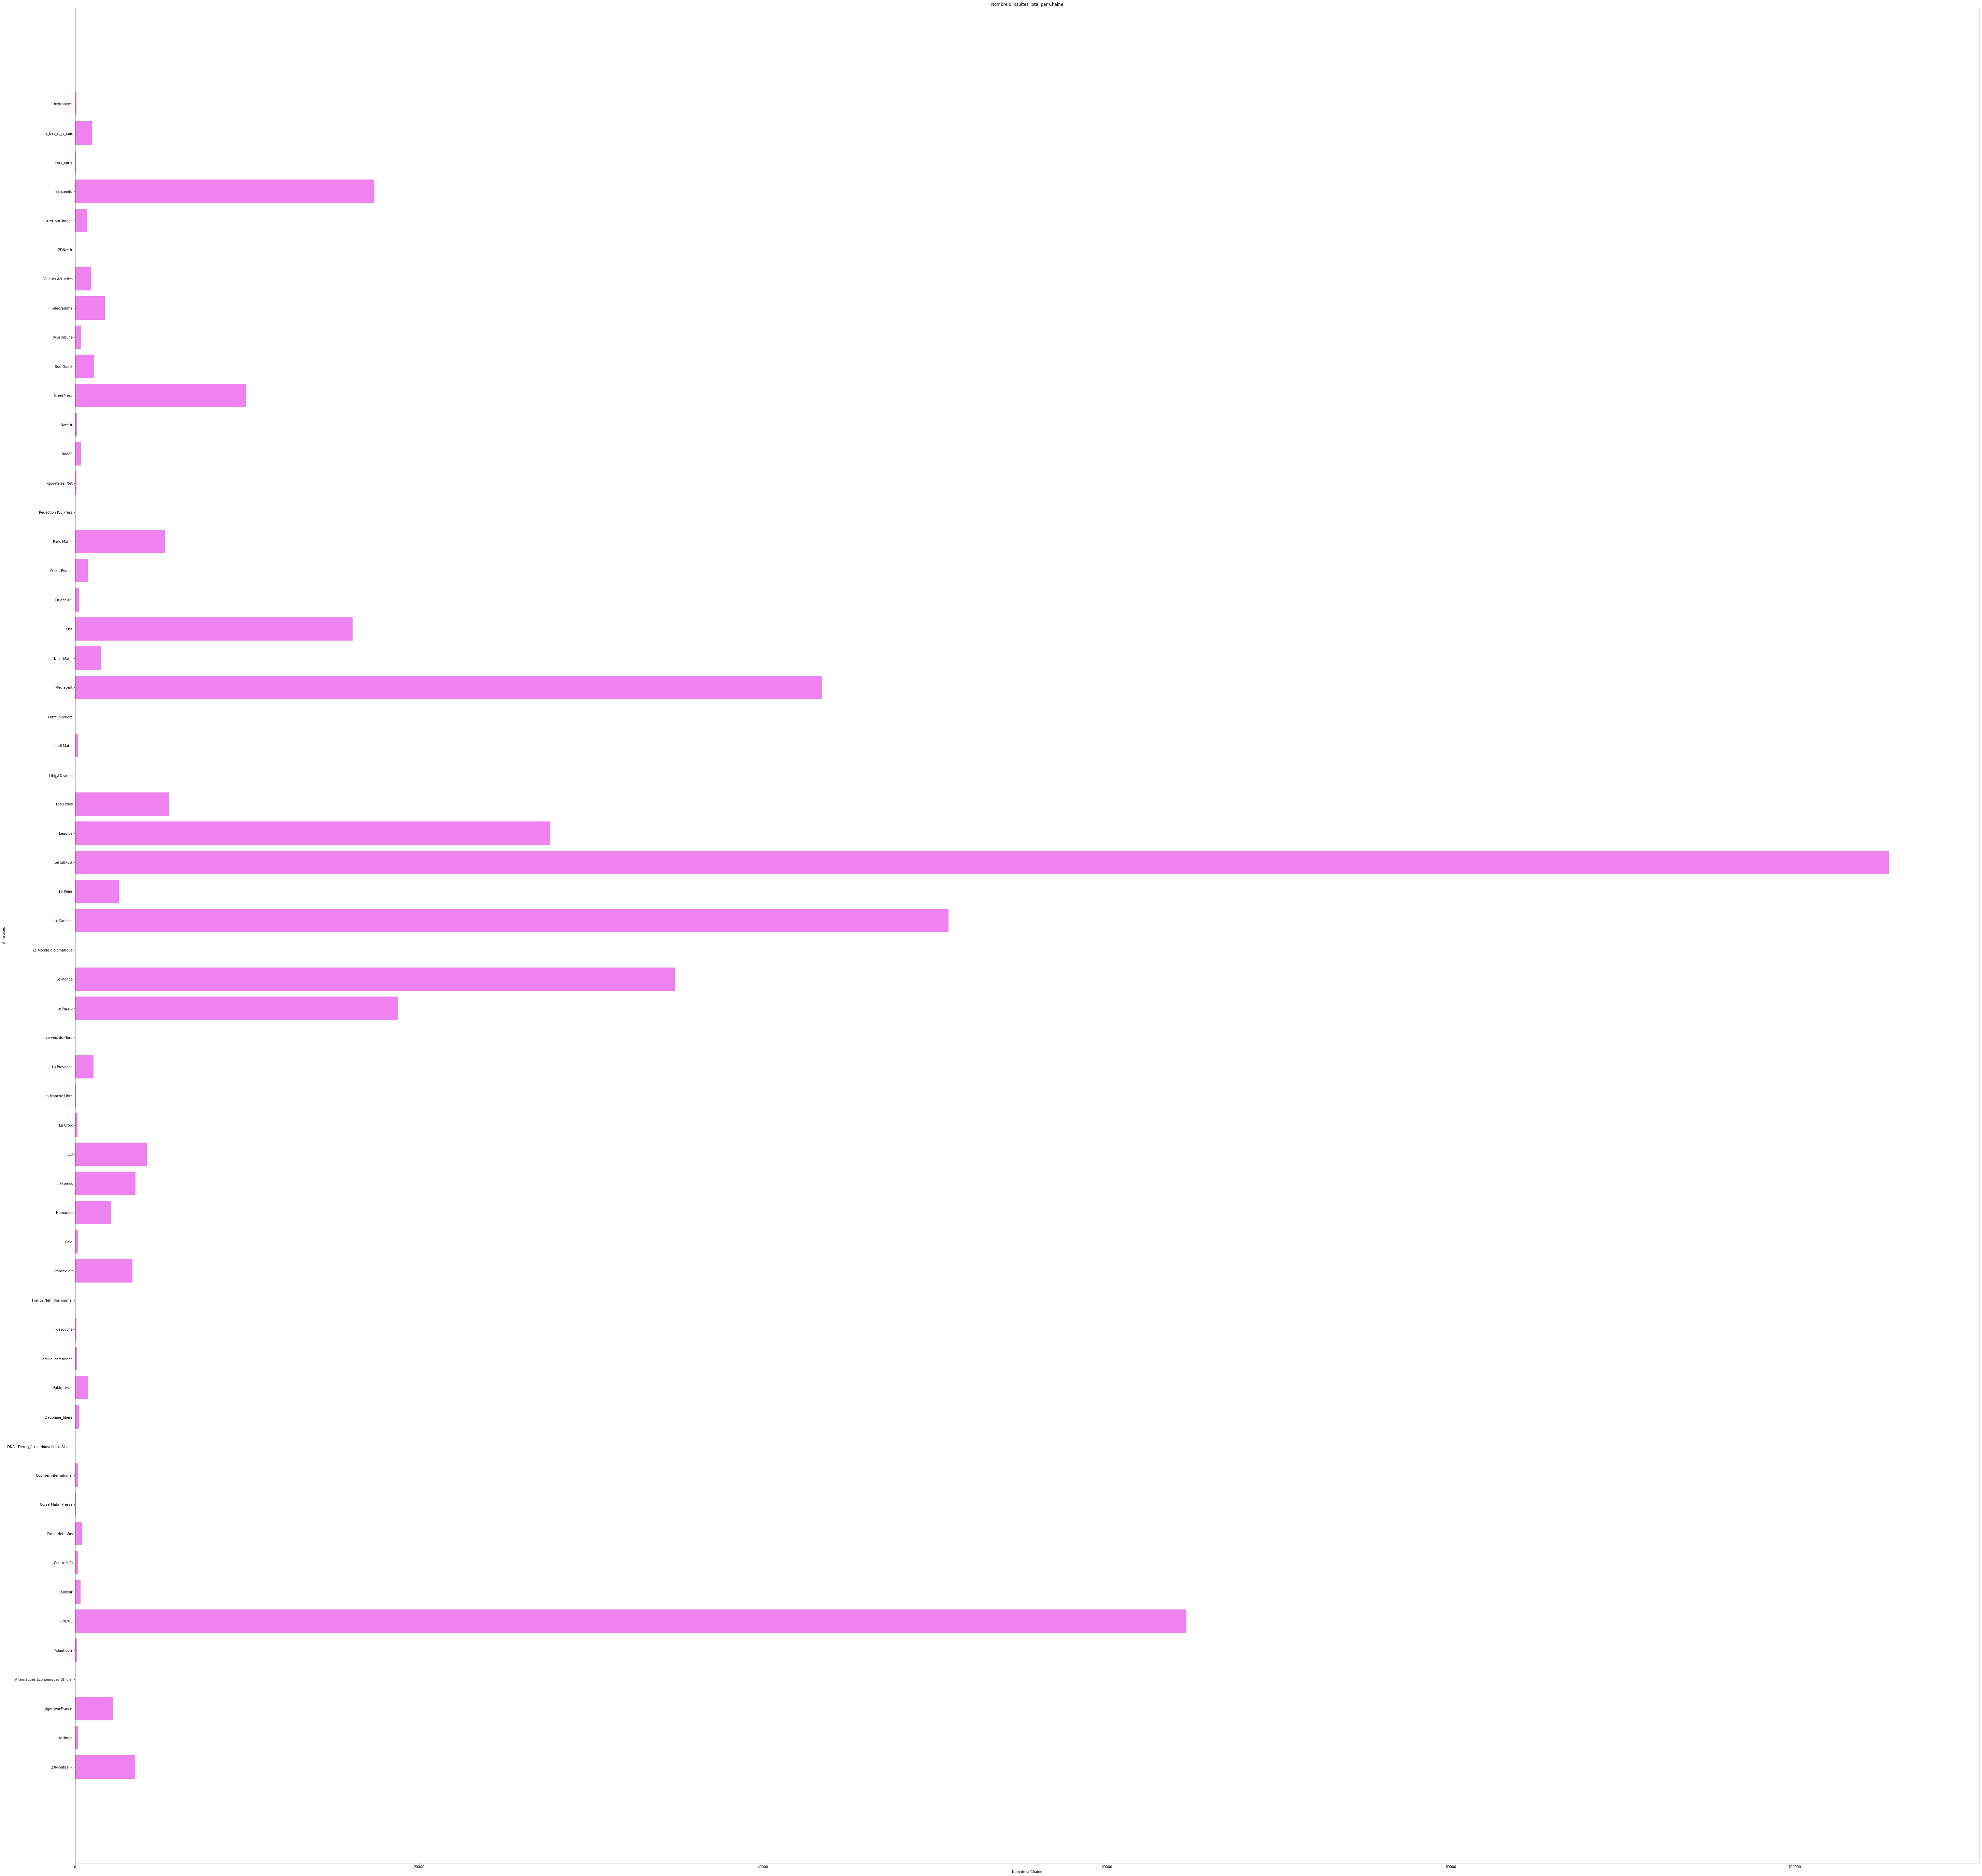

In [ ]:
# Traçons un histogramme permettant l'analyse du Nombre d'Insulte par Chaine
plt.title("Nombre d'Insultes Total par Chaine")
plt.barh(df_channel.channel_name,df_channel.nbrMotInsulte,color = "violet")
plt.xlabel("Nom de la Chaine")
plt.ylabel("# Insultes")

**Conclusion intermédiaire :** Nous remarquons que certaines chaines YouTube ont un plus grand nombre de mots d'insultes que les autres : CNews, Le Parisien, Le Huff Post, Le Monde, Media Part. 

Ainsi, **pour les chaines de grands titres de la presse ou de médias exclusivement disponibles en ligne semblent avoir un plus grand nombre d'insultes en commentaires**. Il faudra vérifier cela avec une analyse par catégorie.

##### *Analyses Ratio nbrMotInsulte/nbrMot par Chaine*

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


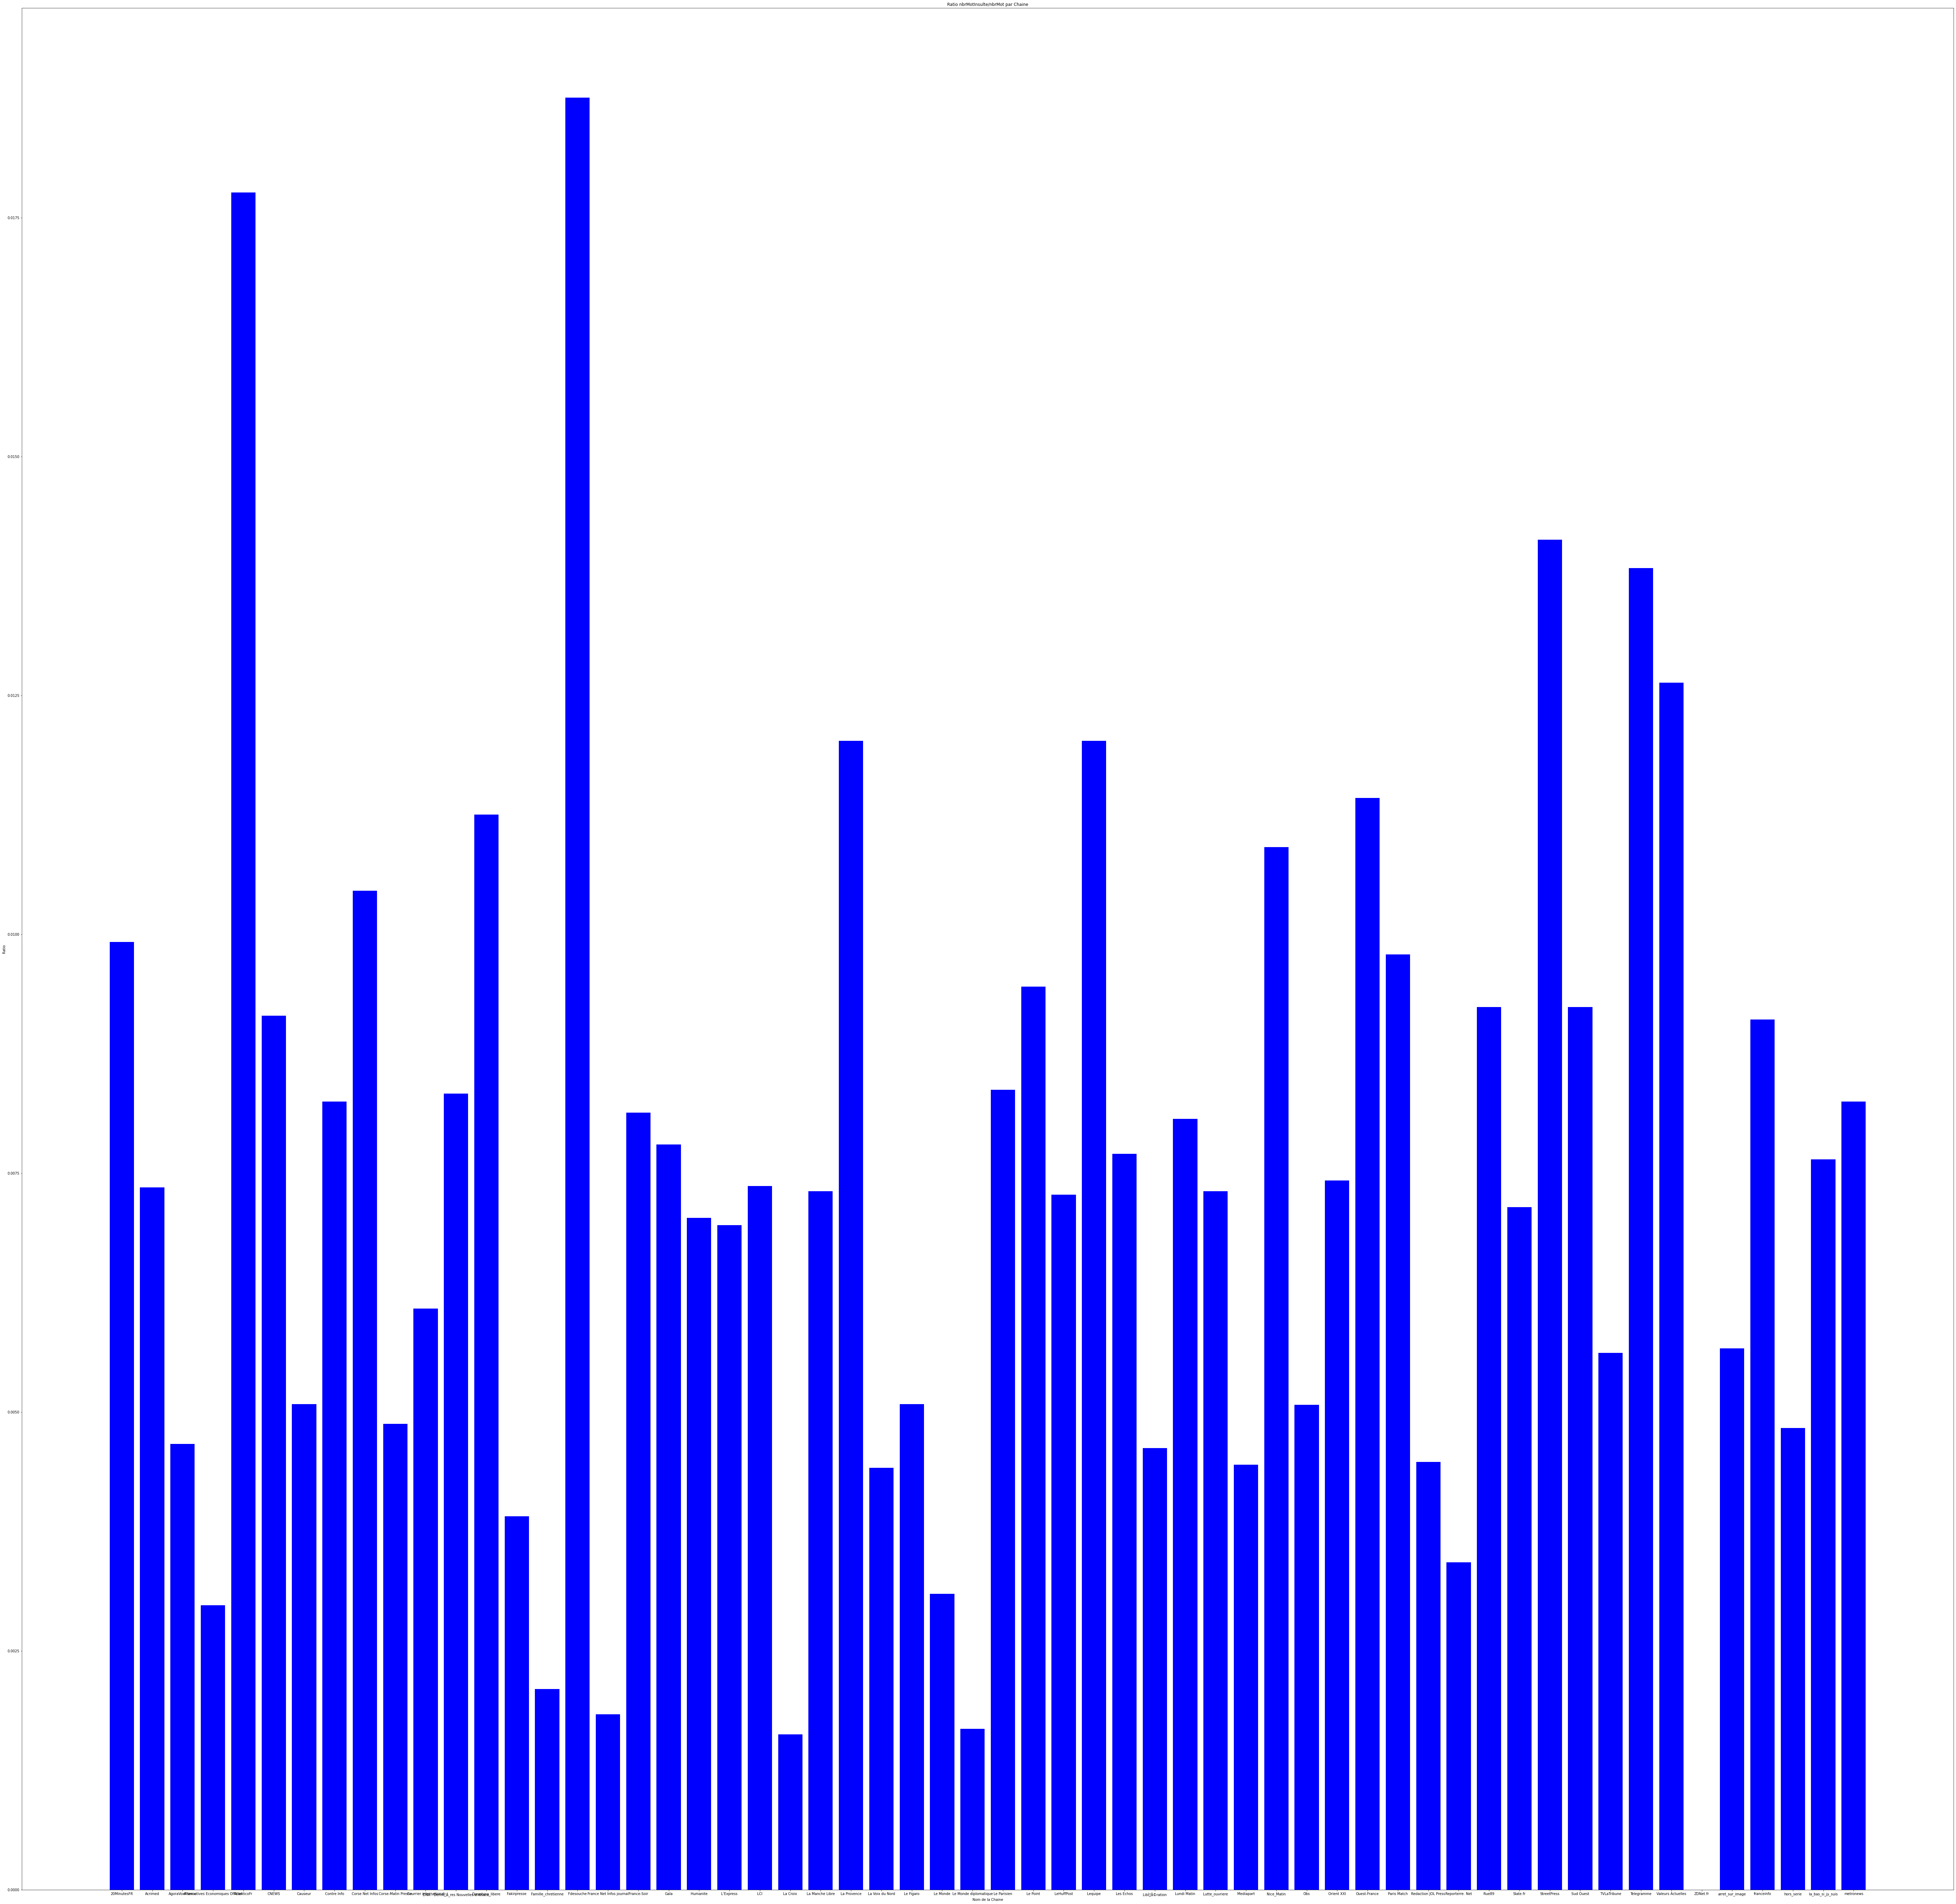

<Figure size 7200x7200 with 0 Axes>

In [ ]:
ratio_insulte = list(df_channel.nbrMotInsulte/df_channel.nbrMot)
plt.title("Ratio nbrMotInsulte/nbrMot par Chaine")
plt.bar(df_channel.channel_name,ratio_insulte, color = "blue")
plt.xlabel("Nom de la Chaine")
plt.ylabel("Ratio")
plt.figure()
plt.rc('figure', figsize=[200, 200])

**Conclusion intermédiaire :** En calculant le ratio Total Insultes/Nombre Totale Mots, nous remarquons que **les chaines arrivant en tête ne sont pas les mêmes que pour l'analyse précédente** : Atlanticofr, Fdesouche, Le Monde Libre, Le Huff Post, Valeurs Actuelles, Télégramme, Street Press. 

Nous remarquons donc que des **médias assez marqués politiquement parlant** (Valeurs Actuelles, le Monde Libre, Fdesouche...) **ont les chaines YouTube avec les plus grands ratios : Total Insultes/Nombre Totale Mots**. Cela semble logique car ils sont sujets à controverse. 

Cela est particulièrement vrai pour fdeSouche qui est la branche d'un parti politique d'extrême droite connu pour ces actions radicales.

Les **grands titres de la presse ont aussi un ratio assez élevé**, ce qui semble logique car il s'agit de médias relativement consultés. 

##### *Analyses insultes/subscribers par Chaine*

Il semble aussi intéressant de regarder quelles sont les **chaines avec le plus de commentaires par souscripteurs**. 

In [ ]:
# Créons une fonction permettant de calculer le ratio voulu
def ratio_insulte_subs(df):
    result = 0 
    if df.subscriberCount != 0:
        result = df.nbrMotInsulte/df.subscriberCount
    return result 
df_channel["Ratio_Insulte_Subs"]= df_channel.apply(lambda row : ratio_insulte_subs(row), axis = 1)

# Créons maintenant le graphique
plt.title("Insultes/Commentaires par Chaines")
plt.xlabel("Chaine")
plt.ylabel("Ratio")
plt.barh(df_channel.channel_name, df_channel.Ratio_Insulte_Subs, color = 'mediumturquoise')
plt.figure()
plt.rc('figure', figsize=[15, 15])

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 14400x14400 with 0 Axes>

**Conclusion intermédiaire :** Ici, avec cette analyse, nous pouvons remarquer que **AtlanticoFr est le média avec le plus d'insultes par souscripteur** (plus d'une insulte par abonnés). 

Les **médias assez orientés politiquement** parlant sont parmi les plus **hauts scores** au niveau des insultes/abonnés. 

**Cette donnée est à relativiser car ce ratio est très sensibles aux nombres de vidéos et aux nombres de souscripteurs**. 

##### *Conclusion Générale Analyse par Chaine*

Au vue des trois analyses précédentes, nous pouvons **supposer que le "channel_name" a un impact sur "nbrMotInsulte"**, la variable que nous cherchons à prédire, dans un premier temps. 

Nous pouvons conclure grâce à l'analyse générale que les **médias tradionnels, les chaines de télé ou les pure players sont les plusa actifs sur YouTube** mais ne sont **pas** pour autant **ceux ayant le plus grand nombre de vue moyen par vidéo**. 

#### **Analyse par catégorie**

##### *Analyse par catégorie new*

Dans l'analyse précédente, nous avons évoqué le fait de réaliser une analyse par catégorie, les catégories pourraient potentiellement faire apparaitre des informations importantes pour notre problème de régression. 

In [ ]:
# Dataframe par categorie_new qui sera utilisé pour nos analyses
df_cat_new = df_youtube.groupby(["categorie_new"]).agg({"nbrMot":"sum","nbrMotInsulte":"sum","video_id":"count","viewCount":"sum","subscriberCount":"mean"}).reset_index()
df_cat_new

,categorie_new,nbrMot,nbrMotInsulte,video_id,viewCount,subscriberCount
0,Core,62403049,395327,38101,3902259643254,179369.741240
1,Niche,2747562,32828,6873,320316471547,155129.748872
2,Partisan,1045110,6044,1128,44192095900,30305.358156


Text(0.5, 0, '# Vidéos')

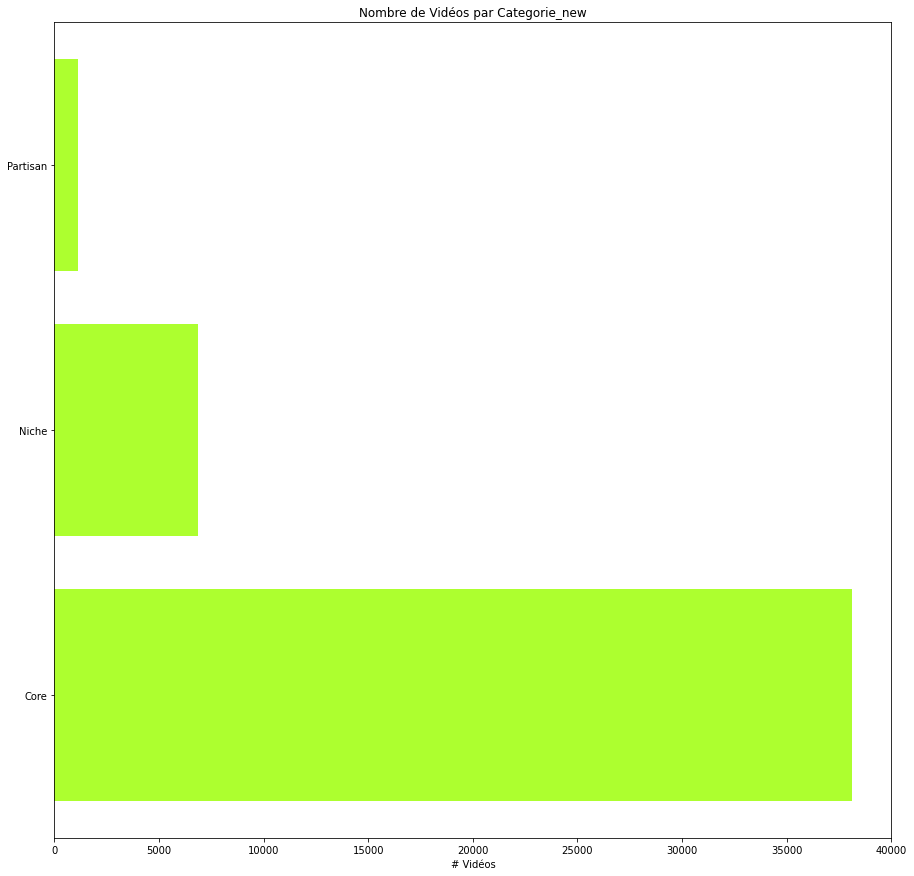

In [ ]:
# Graphe presentant  le nombre de vidéos par categorie_new
plt.title("Nombre de Vidéos par Categorie_new")
plt.barh(df_cat_new.categorie_new,df_cat_new.video_id, color = 'greenyellow')
plt.xlabel("# Vidéos")

**Conclusion Intermédiaire:**Nous pouvons voir que la plus grande quantité de vidéo est publiée par la catégorie core .Cependant nous pouvons peut etre dire que dans cette catégorie nous aurons plus d'injures que les autres catégorie.Pour cela voyons le nombre d'injure par catégorie. 

Nous allons maintenant regarder si la typologie du média influence fortement le nombre de vues par vidéo.

<BarContainer object of 3 artists>

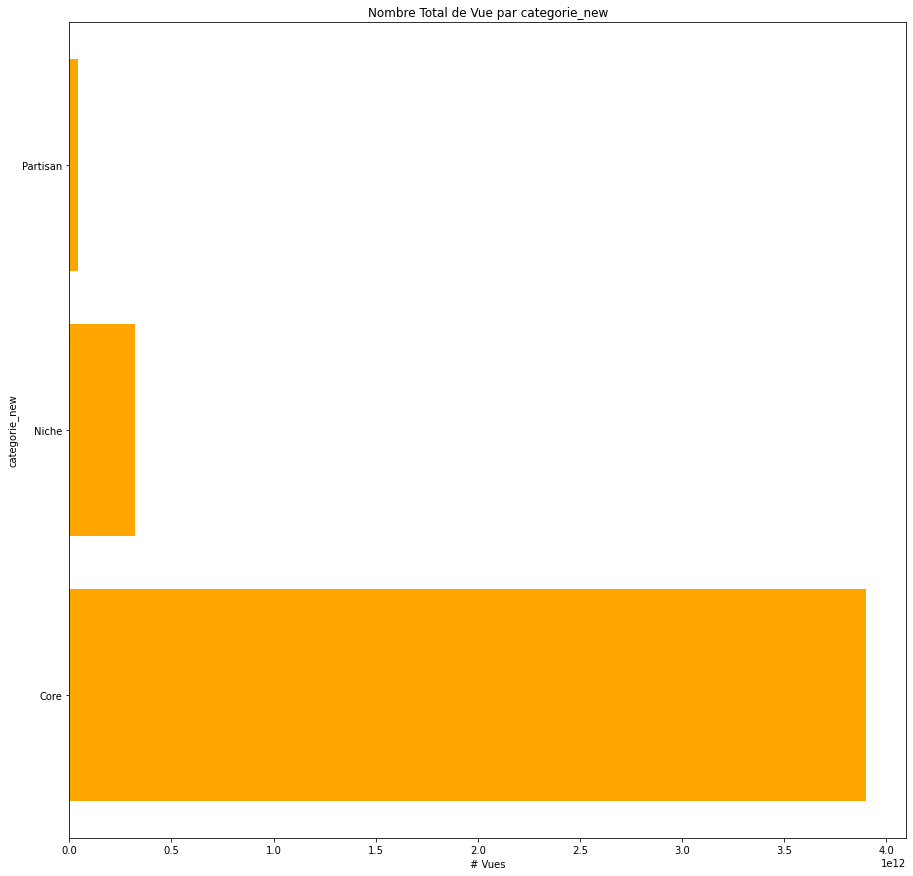

In [ ]:
# Analysons maintenant le nombre de vues par categorie_new
plt.title("Nombre Total de Vue par categorie_new")
plt.xlabel("# Vues")
plt.ylabel("categorie_new")
plt.barh(df_cat_new.categorie_new,df_cat_new.viewCount, color = 'orange')

**Conclusion intermédiaire :** Les médias généralistes ont la plus grande audience. Il est donc normal que le nombre de vues pour ces médias soit le plus important de manière absolue.

Regardons maintenant si rapporté au nombre de vidéos cela est toujours vrai.

<BarContainer object of 3 artists>

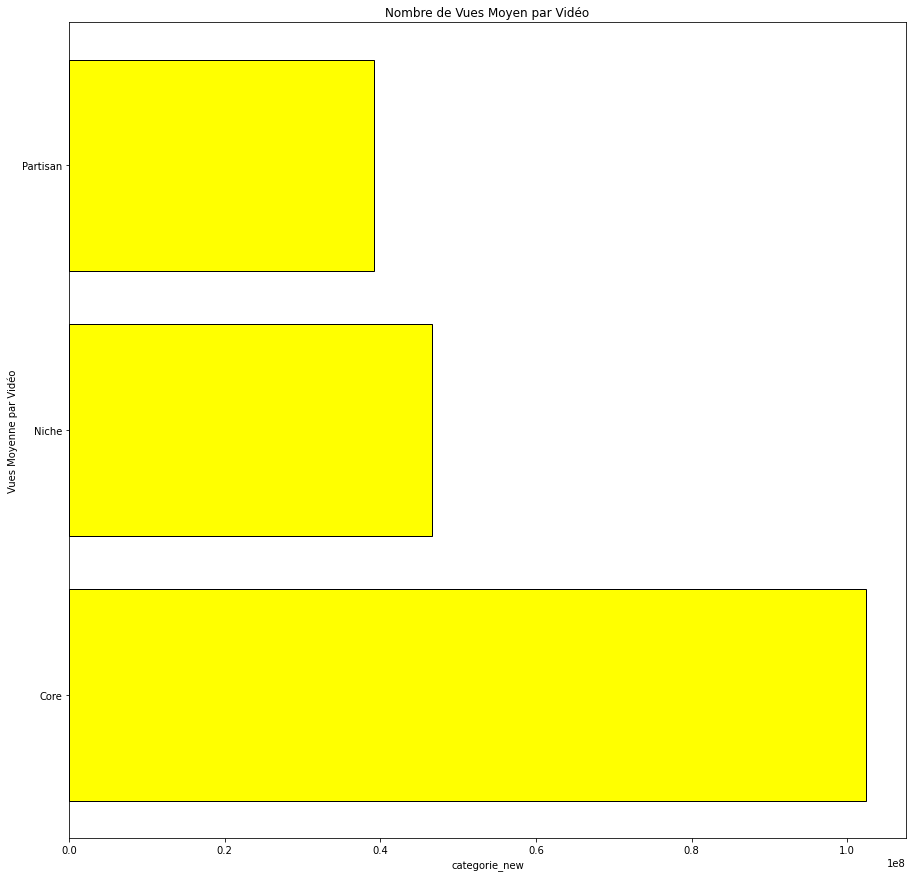

In [ ]:
# Déterminons le nombre de vue moyen par vidéo. Pour cela, ajoutons une colonne au dataframe df_cat_new
def vue_video(df):
  result = 0
  if df.video_id != 0:
    result = df.viewCount/df.video_id
  return result 
df_cat_new["Ratio_Vue"]=df_cat_new.apply(lambda row : vue_video(row), axis = 1)

# Traçons le graphique et concluons cette partie
plt.title("Nombre de Vues Moyen par Vidéo")
plt.xlabel("categorie_new")
plt.ylabel("Vues Moyenne par Vidéo")
plt.barh(df_cat_new.categorie_new,df_cat_new.Ratio_Vue,color = 'yellow', edgecolor = "black")

**Conclusion intermédiaire :** Cela est toujours vrai si on divise par le nombre de vidéos mais l'écart à très fortement diminué. Nous sommes passé d'une différence de l'ordre de 1 pour 10 à 1 pour 3.

Regardons maintenant la proportion d'insulte par catégorie de manière globale.

le total est 434199


Text(0.5, 0, '# Nbre de motInsulte')

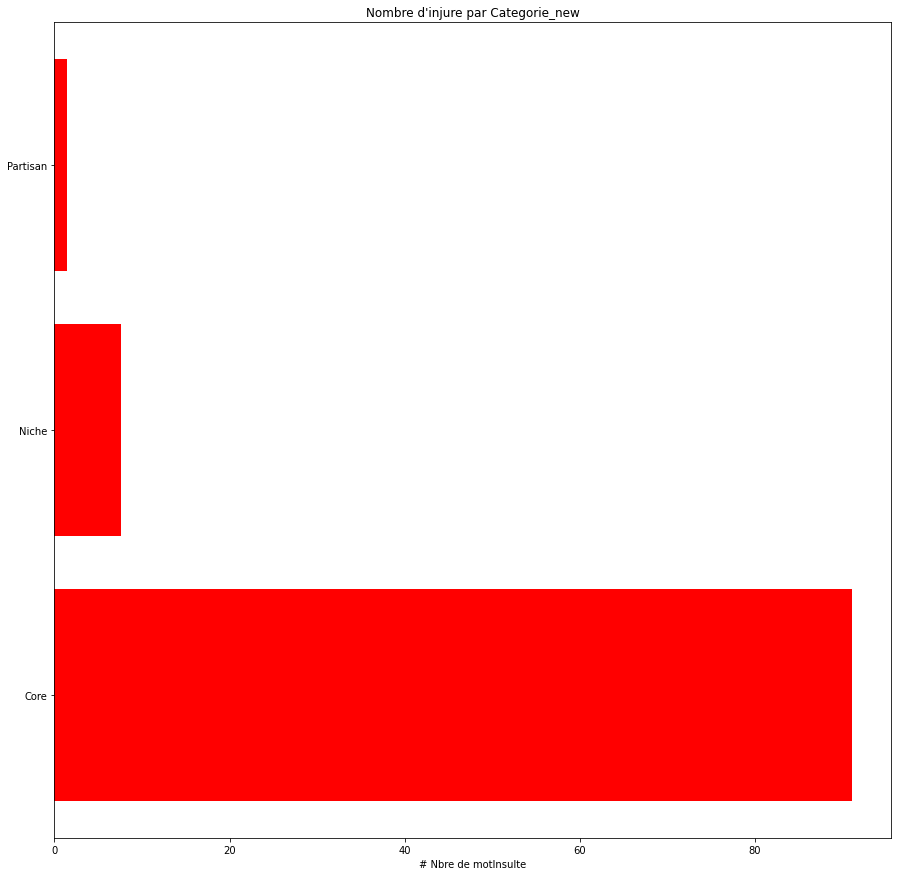

In [ ]:
# Graphe presentant  la proportion de motInsulte par categorie_new
plt.title("Nombre d'injure par Categorie_new")
total=0
for i in [0,1, 2]:
  total=total+df_cat_new.nbrMotInsulte[i]


print("le total est",total)
plt.barh(df_cat_new.categorie_new,(df_cat_new.nbrMotInsulte/total)*100, color = 'red')
plt.xlabel("# Nbre de motInsulte")

**Conclusion intermédiaire :** La part que représente les médias core sur le nombre total d'insulte est très importante. Cela s'explique certainement par le nombre plus important de vidéos et de vues de cette catégorie.


Regardons maintenant le ratio du nombre d'insultes par nombre de mots dans les commentaires.

Text(0, 0.5, 'Ratio')

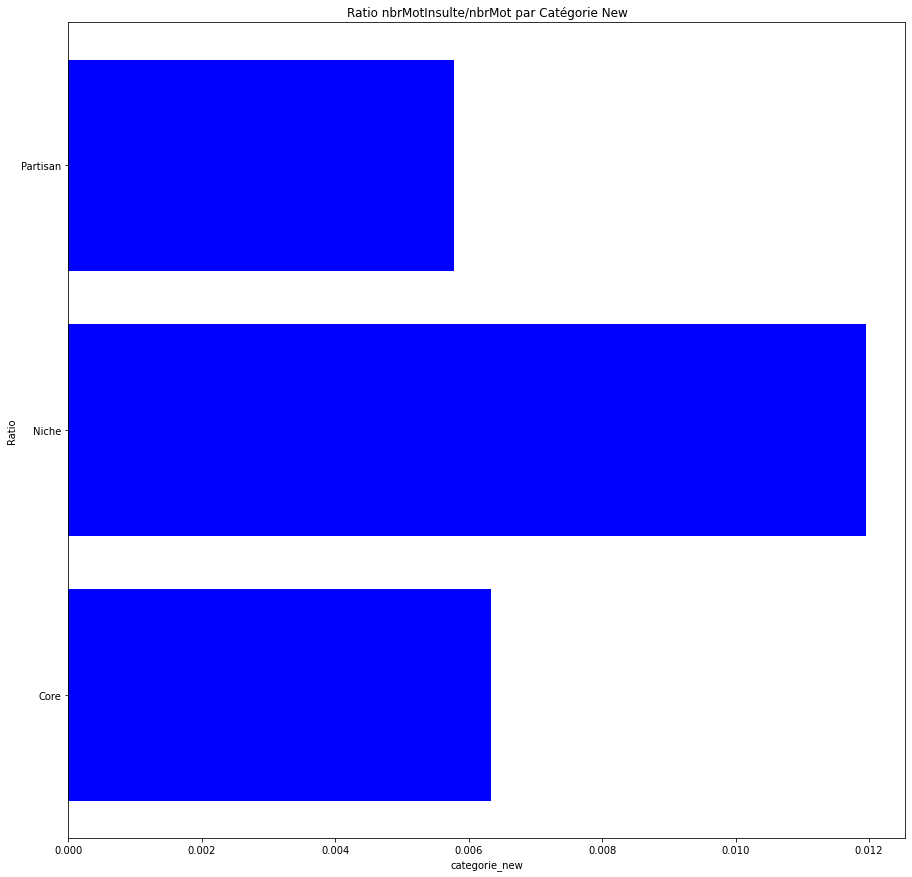

In [ ]:
ratio_insulte = list(df_cat_new.nbrMotInsulte/df_cat_new.nbrMot)
plt.title("Ratio nbrMotInsulte/nbrMot par Catégorie New")
plt.barh(df_cat_new.categorie_new,ratio_insulte, color = "blue")
plt.xlabel("categorie_new")
plt.ylabel("Ratio")

**Conclusion intermédiaire :** Cette fois les médias de niche sont en tête. Une manipulation rapide du tableau des données nous montre que sur les dix articles de catégories niche ayant le plus d'insulte 8 proviennent de l'équipe. Il semble correct de dire que le sport attise les passions.

Il est d'ailleurs intéressant de voir que l'équipe est surreprésenté dans la catégorie niche avec 4 800 des 6 800 vidéos de la catégorie.

Regardons maintenant si cela est lié aux nombres d'abonnés aux différentes catégories. Il serait possible d'envisager que les abonnés des médias génréalistes sont plus nombreux et donc globalement moins viruleux.

<BarContainer object of 3 artists>

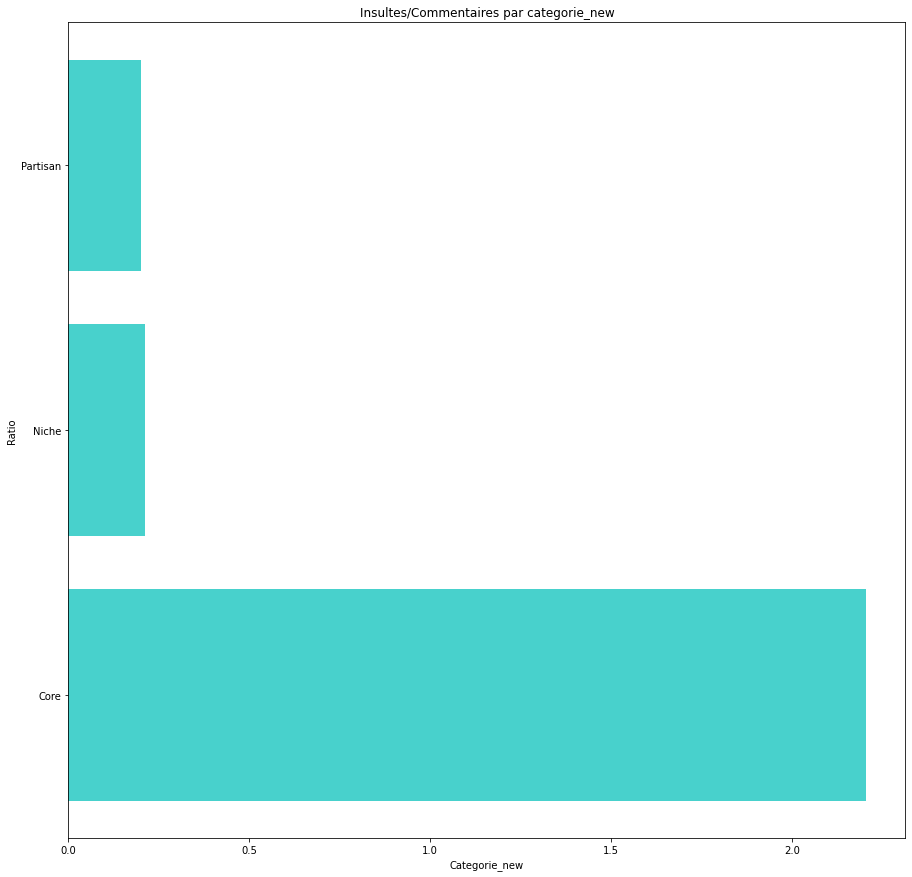

In [ ]:
# définissons une fonction permettant de calculer le ratio voulu
def ratio_insulte_subs(df):
    result = 0 
    if df.subscriberCount != 0:
        result = df.nbrMotInsulte/df.subscriberCount
    return result 
df_cat_new["Ratio_Insulte_Subs"]= df_cat_new.apply(lambda row : ratio_insulte_subs(row), axis = 1)

# Traçons maintenant le graphique
plt.title("Insultes/Commentaires par categorie_new")
plt.xlabel("Categorie_new")
plt.ylabel("Ratio")
plt.barh(df_cat_new.categorie_new, df_cat_new.Ratio_Insulte_Subs, color = 'mediumturquoise')

**Conclusion intermédiaire :** Cela ne semble pas être le cas. Les abonnés des médias généraliste écrivent en moyenne plus d'insultes en commentaire de vidéos.

**Conclusion de sous partie :** Les vidéos des médias core ont globalement plus d'insulte en commentaire que ce soit en termes relatifs ou absolus. Cela s'explique par le plus grand audimat de ces médias qui a la particularité de ne pas noyer les insultes dans la masse des commentaires car les taux relatifs restent élevés.

##### *Analyse par catégorie institutionnelle* 

Text(0.5, 0, '# Vidéos')

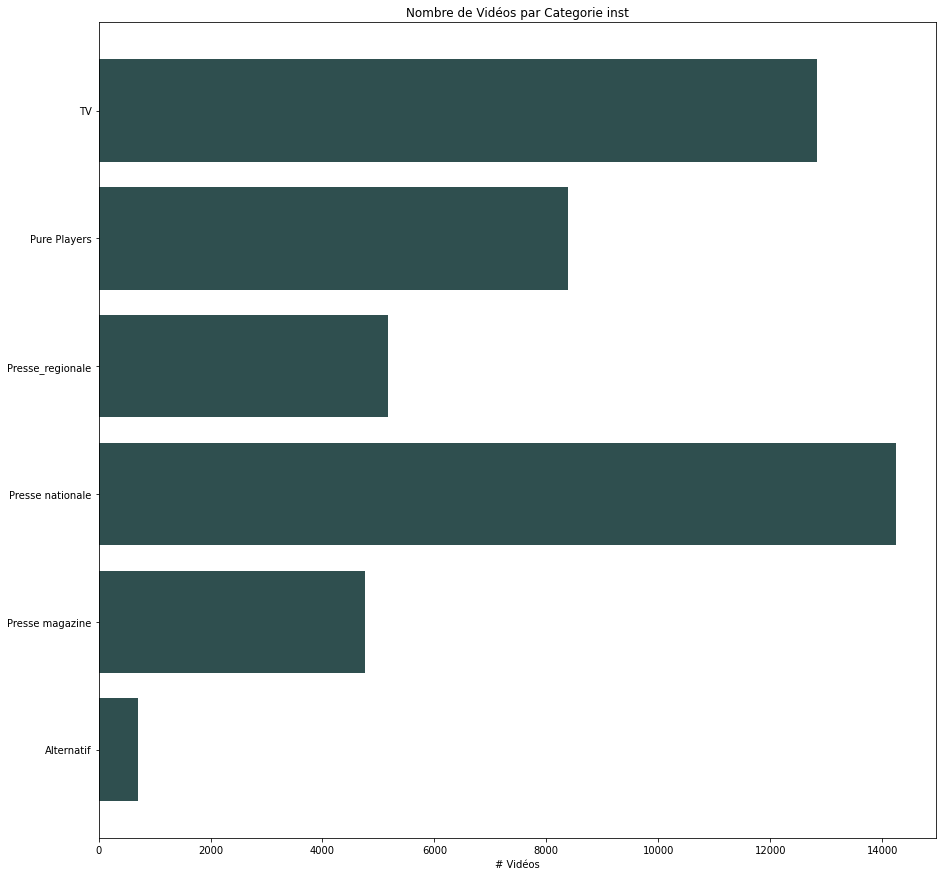

In [ ]:
# Graphique presentant le nombre de vidéos par categorie inst
df_cat_inst = df_youtube.groupby(["categ_inst"]).agg({"nbrMot":"sum","nbrMotInsulte":"sum","video_id":"count","viewCount":"sum","subscriberCount":"mean"}).reset_index()
plt.title("Nombre de Vidéos par Categorie inst")
plt.barh(df_cat_inst.categ_inst,df_cat_inst.video_id, color = 'darkslategrey')
plt.xlabel("# Vidéos")

**conclusion intermédiaire :** Nous aurions pensé que la presse télévisée aurait un nombre de vidéos beaucoup plus important puis que le contenu produit est nativement en format vidéo. C'est le cas. La raison qui explique la domination de la presse nationale est le nombre de chaînes contenues dans cette catégorie 15 contre 3 pour la catégorie TV.

Regardons maintenant le nombre de vues par catégories.

<BarContainer object of 6 artists>

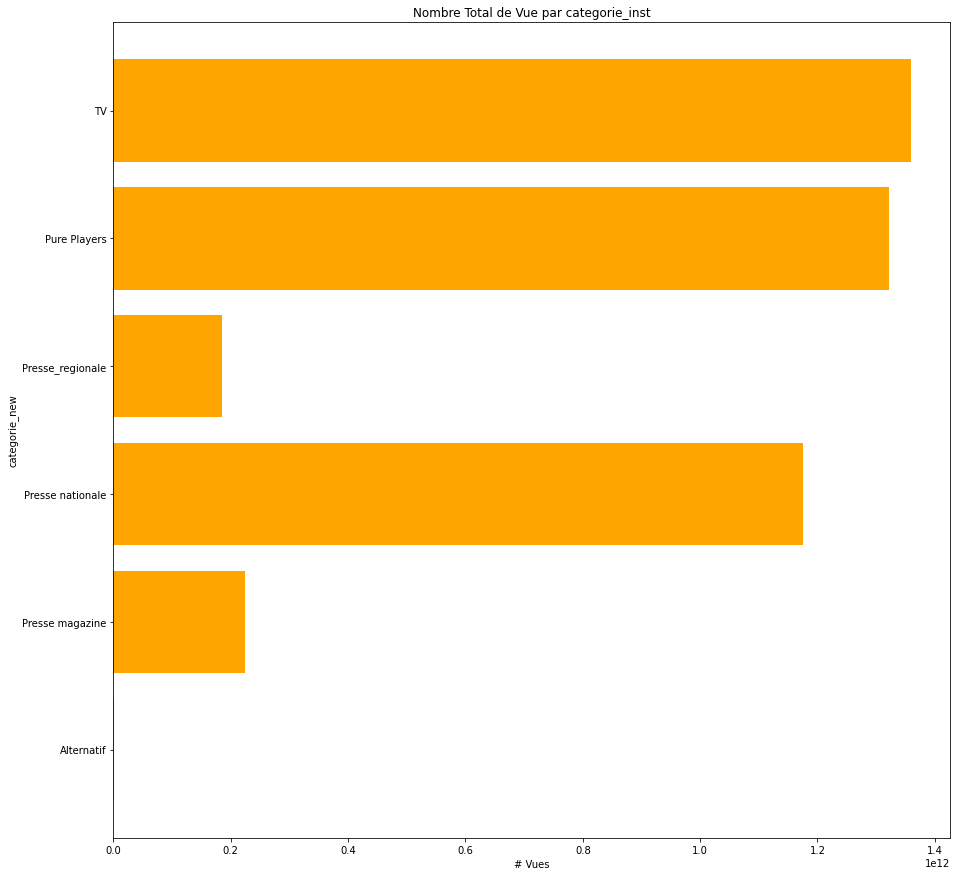

In [ ]:
# Analysons maintenant le nombre de vues par categorie_inst
plt.title("Nombre Total de Vue par categorie_inst")
plt.xlabel("# Vues")
plt.ylabel("categorie_new")
plt.barh(df_cat_inst.categ_inst,df_cat_inst.viewCount, color = 'orange')

Le contenu provenant de chaine TV est celui qui est le plus vu suivi de près par les médias natifs en format web des pure players.

<BarContainer object of 6 artists>

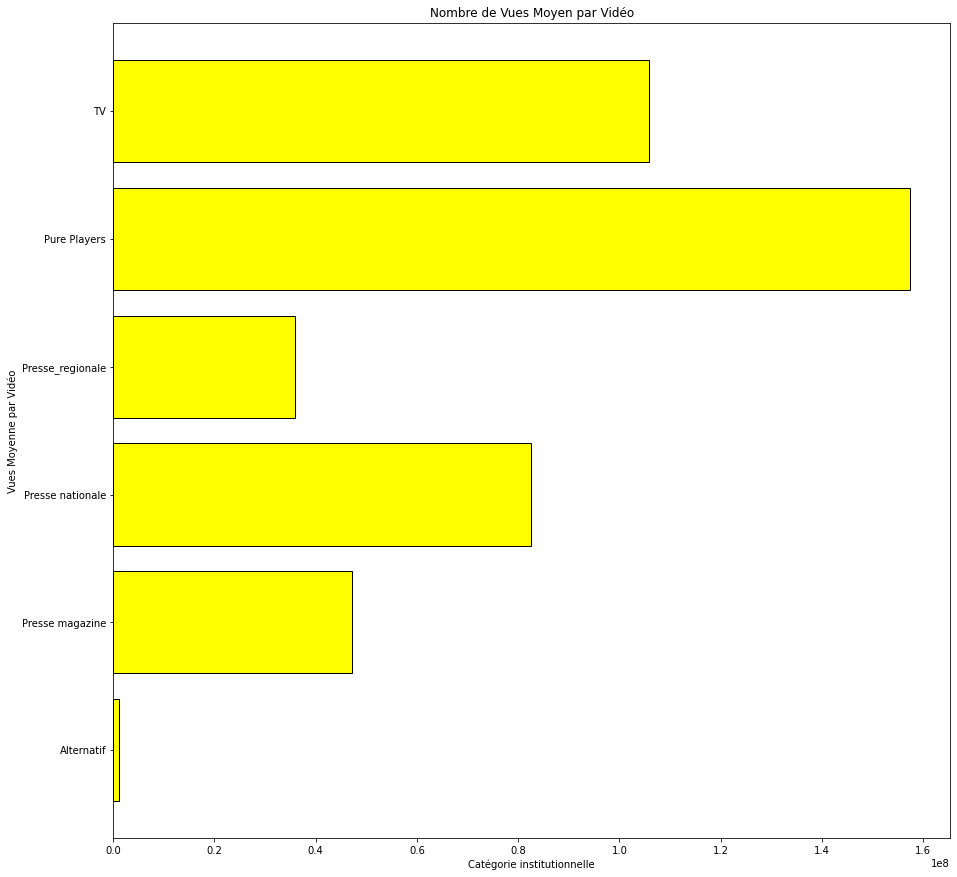

In [ ]:
# Déterminons le nombre de vue moyen par vidéo.
def vue_video(df):
  result = 0
  if df.video_id != 0:
    result = df.viewCount/df.video_id
  return result 
df_cat_inst["Ratio_Vue"]=df_cat_inst.apply(lambda row : vue_video(row), axis = 1)

# Traçons le graphique et concluons cette partie
plt.title("Nombre de Vues Moyen par Vidéo")
plt.xlabel("Catégorie institutionnelle")
plt.ylabel("Vues Moyenne par Vidéo")
plt.barh(df_cat_inst.categ_inst,df_cat_inst.Ratio_Vue,color = 'yellow', edgecolor = "black")

**Conclusion intermédiaire :** Les pure players ont le plus de vue par vidéos cela est notamment dû aux chaînes ayant le plus de vues par vidéos qui sont dans cette catégorie comme Agoravox, leHuffpost et Atlantico.

Regardons maintenant le nombre d'insulte par catégorie de manière absolue.

Text(0, 0.5, '# Insultes')

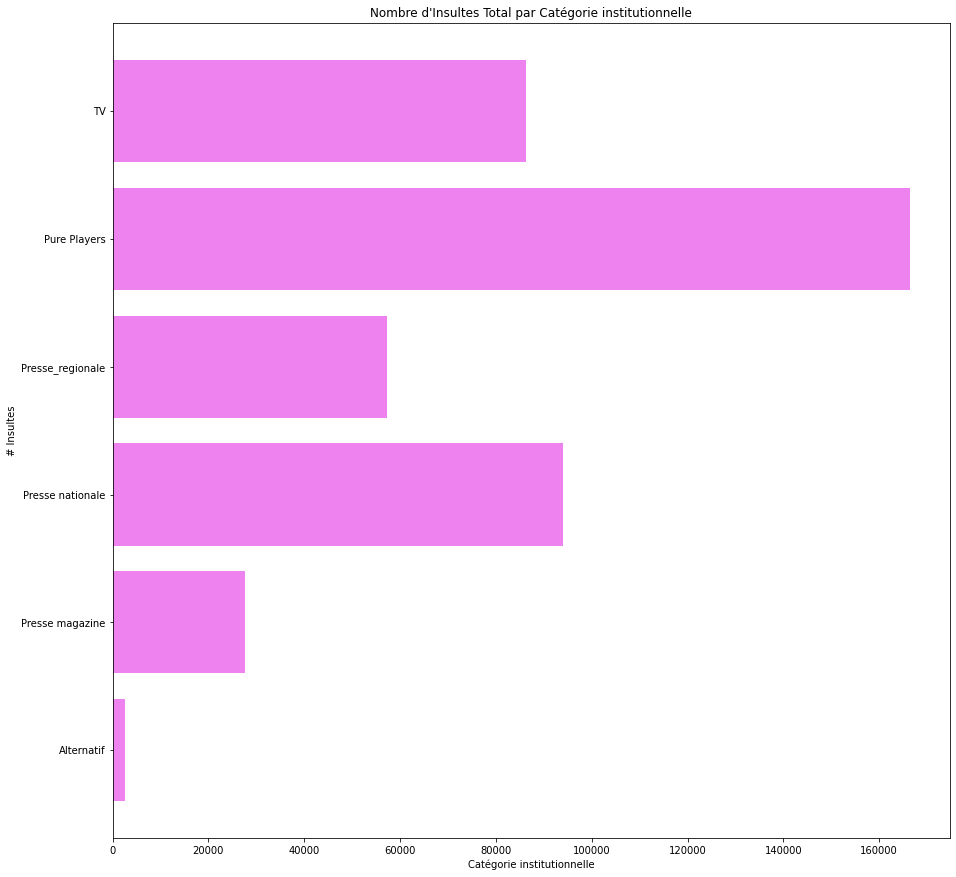

In [ ]:
# Traçons un histogramme permettant l'analyse du Nombre d'Insulte par catégorie institutionnelle.
plt.title("Nombre d'Insultes Total par Catégorie institutionnelle")
plt.barh(df_cat_inst.categ_inst,df_cat_inst.nbrMotInsulte,color = "violet")
plt.xlabel("Catégorie institutionnelle")
plt.ylabel("# Insultes")

**Conclusion intermédiaire :** Le nombre d'insulte est plus important dans la catégorie des pure players et une seule chaine dans cette catégorie représente plus de la moitié des insultes totales de la catégorie lehuffington post. 

Regardons maintenant le nombre de mot d'insulte par nombre de mot en commentaire sur les vidéos en fonction de la catégorie institutionnelle.

Text(0, 0.5, 'Ratio')

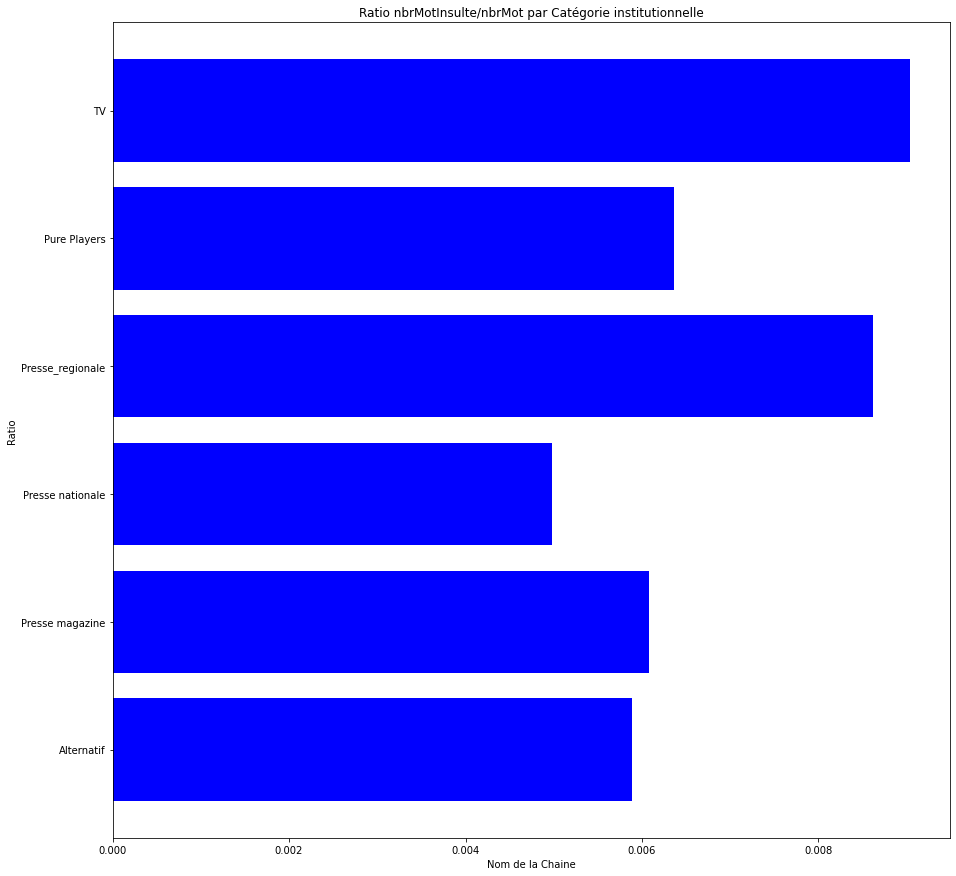

In [ ]:
ratio_insulte = list(df_cat_inst.nbrMotInsulte/df_cat_inst.nbrMot)
plt.title("Ratio nbrMotInsulte/nbrMot par Catégorie institutionnelle")
plt.barh(df_cat_inst.categ_inst,ratio_insulte, color = "blue")
plt.xlabel("Nom de la Chaine")
plt.ylabel("Ratio")

**Conclusion intermédiaire :** La presse régionale et la presse nationale se tiennent dans un mouchoir de poche la différence n'est pas très significative.

##### *Conclusion Générale Analyse par Catégorie*

Mettre la conclusion générale par catégorie. 

#### **Matrice de corrélation**

Avant de passer au feature engineering, nous allons réaliser et commenter une **matrice de corrélation**. Cette dernière nous **permettra d'alléger potentiellement notre dataframe pour la prédiction**. 

##### *Le graphique de corrélation*

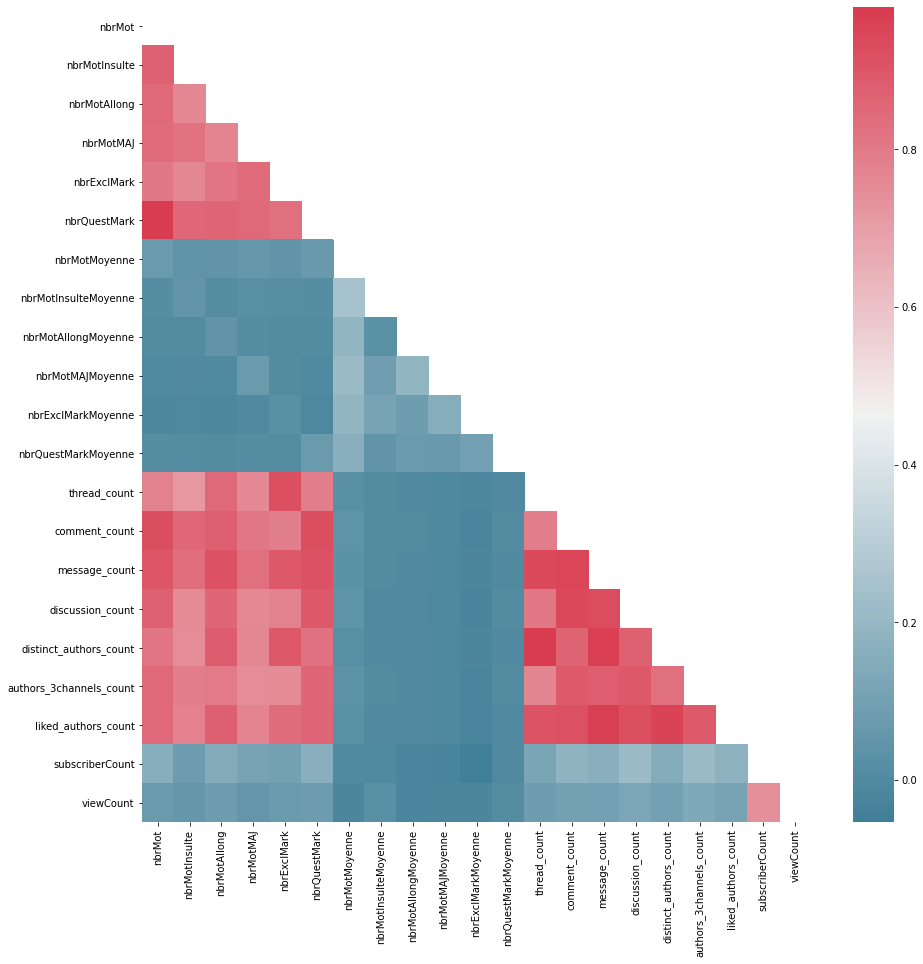

In [ ]:
def plotCorrelationMatrix(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(225, 8, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap)
    plt.rc('figure', figsize=[30, 30])

data_correlation = df_youtube.corr()
plotCorrelationMatrix(data_correlation)

##### *Analyse de la Matrice de corrélation :*

La matrice de corrélation met en évidence de **fortes dépendances entre les variables du jeu de données**. Parmi les **relations les plus fortes**, on remarque des **rapports évidents**, tels que l'augmentation du nombre total de messages lorsque le nombre de commentaires top-level et de réponses à ces commentaires augmente. 

D'autres sont **moins évidents mais explicables** : par exemple entre les **nombres de commentaires top-level et de fils de discussions et le nombre d'auteurs distincts (en effet, les utilisateurs sont rarement auteurs de deux fils)**. De même, il paraît évident que la participation de "stars", c'est-à-dire d'utilisateurs obtenant beaucoup de likes, favorisera la discussion et augmentera le nombre de messages.

Les **résultats les plus intéressants sont ceux pour lesquels on n'a pas d'explication immédiate** : l'**augmentation conjointe du nombre de mots et de points d'interrogation** (les utilisateurs utilisent-ils plus de questions lorsque leurs commentaires sont longs?), le **rapport entre le nombre d'utilisateurs actifs sur 3 plateformes ou plus et ceux obtenant beaucoup de likes** (ces utilisateurs sont-ils les mêmes?).

On peut trouver **étonnant que les valeurs en moyennes soient si décorrélées des valeurs absolues**, et en particulier de la variable dont elles sont dérivées.

Une interprétation possible est que **chaque variable augmente au même rythme le nombre de commentaire, de sorte que les moyennes sont relativement stables par rapport aux variables**. Il est à noter que si ces variables augmentaient significativement moins vite que le nombre de commentaires, on verrait en revanche une corrélation entre les moyennes et la variable message_count, ce qui ne semble pas être le cas.

Enfin, les **nombres d'abonnés et de vues ont peu d'influence sur le reste des variables**. En effet, les chaînes sélectionnées étant surtout des chaînes d'information, elles attirent toutes un certain nombre d'utilisateurs souhaitant débattre, mais surtout beaucoup d'autres qui veulent juste s'informer, et qui participeront aux abonnements et aux vues sans participer aux discussions.

#### **Cercle de corrélation**

A la suite de la matrice de corrélation, nous avons jugé utile de réaliser un **cerle de corrélation**. A l'aide de ce dernier, nous allons chercher à **reduire le nombre de features du dataframe**. Le but est d'avoir un dataframe propre et simplifiée pour la réalisation de nos prédictions. 

##### *Réalisation du cercle de corrélation :*

In [ ]:
def scale(data):
    scaled_data = preprocessing.StandardScaler().fit_transform(data)
    return(scaled_data)

In [ ]:
def pca(scaled_data):
    pca_results = decomposition.PCA().fit(scaled_data)
    return(pca_results)

In [ ]:
def plotCorrelationCircle(pca_components,xlim,ylim,label_df):
    for i, (x, y) in enumerate(zip(pca_components[0,:], pca_components[1,:])):
        plt.plot([0, x], [0, y], color='k')
        if xlim[0]<x and xlim[1]>x and ylim[0]<y and ylim[1]>y:
          plt.text(x, y, label_df.columns[i])
    plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.title("Cercle de Correlation")
    plt.rc('figure', figsize=[10, 10])

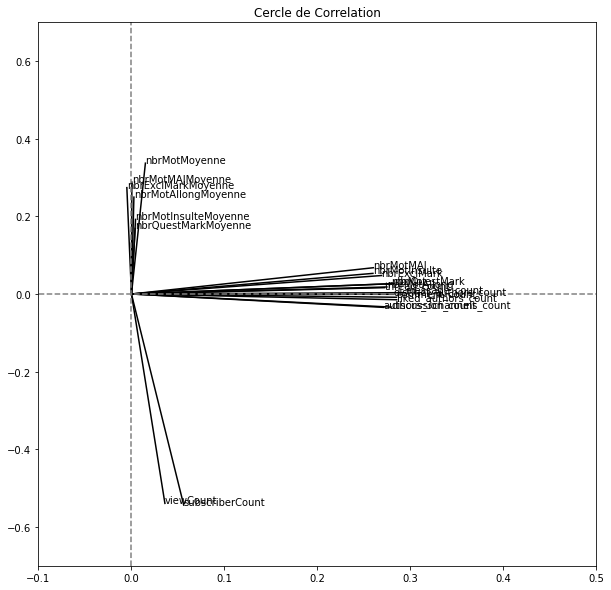

In [ ]:
youtube_df_analysis = df_youtube.drop(labels=['video_id_court','video_id','channel_id','channel_name','categorie_new','categ_inst'],axis=1).copy()
scaled_youtube_df = scale(youtube_df_analysis)
pca_components = pca(scaled_youtube_df).components_
plotCorrelationCircle(pca_components,[-0.1,0.5],[-0.7,0.7],youtube_df_analysis)

Du cercle précédent, nous ne pouvons pas réellement tirer d'information, l'**échelle ne permet pas de distinguer la plupart des variables**. Néanmoins, ce graphique reste intéressant et porteur pour nos analyses suivantes. **Nous le conservons donc et effectuons un zoom afin de mieux distinguer les résultats**. 

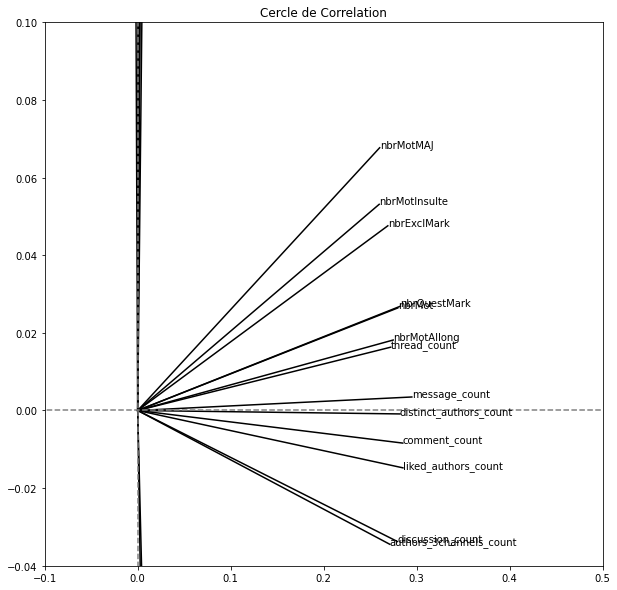

In [ ]:
plotCorrelationCircle(pca_components,[-0.1,0.5],[-0.04,0.1],youtube_df_analysis)

Grâce à ce zoom, nous allons pouvoir **tirer certaines conclusions et proposer une démarche pour la suite de l'analyse**. 

##### *Conclusions :*

Tout d'abord, les variables **viewCount et subscriberCount ne semblent pas corrélés avec la variable nbrmotInsulte** que nous cherchons à prédire (angle de 90°). Nous allons donc **les enlever** du dataframe pour la prédiction. 

**Data leakage :**

Les **moyennes représentent pour nous du data leakage** (information qui ne seraient pas vraiment disponibles dans la vraie vie). Nous avons donc aussi décidé de les enlever. De plus, quand nous avons **une métrique comme nbrMotInsulteMoyenne, à l'aide de cette dernière et de la variable message_count, nous pouvons très facilement arriver à retrouver nbrMotInsulte**. La variable que nous cherchons à prédire. **Dans la réalité, nous n'aurons pas le nbrMotInsulte/nombre commentaire sous la vidéo si nous cherchons à prédire le nombre d'insultes totales**. 

Ces moyennes **risquent de mener à de l'overfitting**. 

##### *Création du dataframe pour la prédiction:*

In [ ]:
# Nous enlevons aussi les informations inutiles comme les id_vidéos ou le channel_id (nous utiliserons ces informations de manière encodée)
youtube_prediction = df_youtube.drop(["video_id_court","video_id","channel_id","nbrMotMoyenne","nbrMotInsulteMoyenne","nbrMotAllongMoyenne","nbrMotMAJMoyenne","nbrExclMarkMoyenne","nbrQuestMarkMoyenne","subscriberCount","viewCount"], axis = 1).copy()

Nous utiliserons donc ce **nouveau dataframe pour tous nos modèles de prédiction** de la valeur nbrMotInsulte. 

Potentiellement, ce dernier sera amené a **évolué légérement pour la régression linéaire**. Nous utiliserons une méthode de **"backward elimination"**. 

#**Encoding des Variables Chaines de Caractères**

Encodons les valeurs chaines de caractères à l'aide de la fonction **LabelEncoder**

In [ ]:
labelencoder = LabelEncoder()
youtube_prediction['channel_name']=labelencoder.fit_transform(youtube_prediction['channel_name'])
youtube_prediction['categorie_new']=labelencoder.fit_transform(youtube_prediction['categorie_new'])
youtube_prediction['categ_inst']=labelencoder.fit_transform(youtube_prediction['categ_inst'])

#**Prédiction nbrMotInsulte**

Afin d'évaluer les différents modèles de régression, nous utiliserons des metrics comme la **MAE**. La définition de ces metrics sont disponibles ici : https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b. 

Sur ce site, on peut aussi trouver des justifications sur le choix des metrics pour les modèles de régression. 

D'autres méthodes d'évaluation pourront bien évidemment être utilisées et leur utilité sera justifiée. 

Afin d'optimiser les paramètres, nous utiliserons les fonctions **GridSearchCV**. Cette fonctions de tuning nous sera d'une grande utilité. 

#### **Mise au point**


*   Nous utiliserons "Bootstrap" pour les Forêts Aléatoires que nous réaliserons, nous ne modifierons pas le paramètre de base bootstrap = True. 

*   Il est sans doute possible d'optimiser encore plus les les MAE (Mean Absolute Error) mais avec nos PC, les temps de calcul sont énormes et nous ne pouvons pas nous permettre de réaliser. 



#### **Train/Test Split**

Commençons par réaliser le split entre les données d'entrainement et de test. Nous allons utiliser une répartition assez classique : **2/3 pour les données de train et 1/3 pour les données de test**. 

In [ ]:
# Séparons les données 
youtube_feature = youtube_prediction.drop(["nbrMotInsulte"],axis=1)
youtube_result = youtube_prediction["nbrMotInsulte"]

X,y = youtube_feature, youtube_result
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(30734, 16) (15368, 16) (30734,) (15368,)


In [ ]:
# Pour certains modèles, il faudra que les data soient centrées et réduite, nous le faisons donc ici
stds = preprocessing.StandardScaler()
Z_train = stds.fit_transform(X_train)
Z_test = stds.fit_transform(X_test)

Maintenant, nous pouvons commencer les prédictions. 

#### **Régression Linéaire**

##### *Entrainement*

Commençons par une régression linéaire. Attribuons un nom raccourci à la fonction et entrainons le modèle. 

Nous donnons un nom raccourci à l'élément pour usage ultérieur.


In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

##### *Test*

In [ ]:
y_pred_linear_regression = lm.predict(X_test)

##### *Evaluation*

In [ ]:
print("En moyenne la distance de la prévision par rapport à la valeur réelle est de :", "%.2f" % metrics.mean_absolute_error(y_test,y_pred_linear_regression),".")
print("\nAinsi, nous arrivons avec les arbres de régression à prédire le nombre d'insultes avec un écart de +/-", "%.2f" % metrics.mean_absolute_error(y_test,y_pred_linear_regression),"mots.")

En moyenne la distance de la prévision par rapport à la valeur réelle est de : 5.52 .

Ainsi, nous arrivons avec les arbres de régression à prédire le nombre d'insultes avec un écart de +/- 5.52 mots.


##### *Conclusion*

Ce **résultat est peu satisfaisant**. Néanmoins, il nous donne une idée de ce qu'il est **possible d'obtenir rapidement en utilisant un modèle peu complexe**.

Les autres modèles seront plus optimisés afin d'essayer de tirer les meilleurs résultats de ces derniers. 

#### **Arbre de régression**

##### *Sélection des meilleurs paramètres*

Comme nous l'avons dit en intoduction nous allons utiliser la fonction **GridSearchCV** pour essayer de trouver les meilleurs paramètres pour chaque modèle. Cette fonction est détaillée dans le lien suivant : 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
# Temps d'execution, environ 2'30 min 
parameters = {
    "max_depth": range(2,20),
    "min_samples_leaf" : range(1,15),
}

model_desicion_tree = tree.DecisionTreeRegressor(random_state=42)
model_desicion_tree = GridSearchCV(
    model_desicion_tree, 
    parameters, 
    cv=5,
    scoring='neg_mean_absolute_error',
)

model_desicion_tree.fit(X_train, y_train)
print('-----')
print(f'Best parameter {model_desicion_tree.best_params_}')
print('-----')

-----
Best parameter {'max_depth': 8, 'min_samples_leaf': 4}
-----


##### *Entrainement du modèle*

In [ ]:
# Récuperons les meilleurs paramètres et entrainons notre modèle
tree_youtube = model_desicion_tree.best_estimator_
tree_youtube = tree_youtube.fit(X_train, y_train)

##### *Prédiction*

In [ ]:
y_pred_tree_youtube = tree_youtube.predict(X_test)

Maintenant que nous avons réalisé la prédiction, il faut **évaluer la qualité de cette dernière**. 

##### *Evaluation*

In [ ]:
print("En moyenne la distance de la prévision par rapport à la valeur réelle est de :", "%.2f" % metrics.mean_absolute_error(y_test,y_pred_tree_youtube),".")
print("\nAinsi, nous arrivons avec les arbres de régression à prédire le nombre d'insultes avec un écart de +/-", "%.2f" % metrics.mean_absolute_error(y_test,y_pred_tree_youtube),"mots.")

En moyenne la distance de la prévision par rapport à la valeur réelle est de : 4.86 .

Ainsi, nous arrivons avec les arbres de régression à prédire le nombre d'insultes avec un écart de +/- 4.86 mots.


##### *Conclusion*

Ce modèle ne semble pas très pertinent, en effet un écart comme celui que nous obtenons **ne permet pas de prédire avec une grande exactitude la variable nbrMotInsulte**. 

**Nous avons une moyenne de 9 insultes, un écart comme celui obtenu avec les arbres de régression est énorme**. 

#### **Méthode K plus proches voisins**

##### *Sélection des meilleurs paramètres*

In [ ]:
param_grid={'n_neighbors':range(1,20),
            'metric':['euclidean','manhattan'],
            "weights":['uniform','distance'],
}
model_desicion_KNN = KNeighborsRegressor()
model_desicion_KNN = GridSearchCV(
    model_desicion_KNN, 
    param_grid, 
    cv=5,
    scoring='neg_mean_absolute_error',
)

model_desicion_KNN.fit(X_train, y_train)
print('-----')
print(f'Best parameter {model_desicion_KNN.best_params_}')
print('-----')



-----
Best parameter {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
-----


##### *Entrainement du modèle*

In [ ]:
KNN_youtube = model_desicion_KNN.best_estimator_
KNN_youtube = KNN_youtube.fit(X_train,y_train)


##### *Prédiction*

In [ ]:
y_pred_KNN = KNN_youtube.predict(X_test)

##### *Evaluation*

In [ ]:
print("En moyenne la distance de la prévision par rapport à la valeur réelle est de :", "%.2f" % metrics.mean_absolute_error(y_test,y_pred_KNN),".")
print("\nAinsi, nous arrivons avec les arbres de régression à prédire le nombre d'insultes avec un écart de +/-", "%.2f" % metrics.mean_absolute_error(y_test,y_pred_KNN),"mots.")

En moyenne la distance de la prévision par rapport à la valeur réelle est de : 5.05 .

Ainsi, nous arrivons avec les arbres de régression à prédire le nombre d'insultes avec un écart de +/- 5.05 mots.


##### *Conclusion*

Ce modèle ne semble pas très pertinent, en effet un écart comme celui que nous obtenons **ne permet pas de prédire avec une grande exactitude la variable nbrMotInsulte**. 

**Nous avons une moyenne de 9 insultes, un écart comme celui obtenu avec la méthode des K plus proches voisins est assez grand**. 

#### **Gradient Boosting**

##### *Sélection des meilleurs paramètres*

In [ ]:
parameters = {
    "max_depth": range(2,20),
    "learning_rate":[0.01,0.1,0.05]
}

model_xgb = xgb.XGBRegressor(objective="reg:squarederror",booster='gbtree')
model_xgb = GridSearchCV(
    model_xgb, 
    parameters, 
    cv=5,
    scoring='neg_mean_absolute_error',
)

model_xgb.fit(X_train, y_train)
print('-----')
print(f'Best parameter {model_xgb.best_params_}')
print('-----')

-----
Best parameter {'learning_rate': 0.05, 'max_depth': 8}
-----


##### *Entrainement du modèle*

In [ ]:
xgbr = model_xgb.best_estimator_
xgbr = xgbr.fit(X_train, y_train)

##### *Test*

In [ ]:
y_pred_xgbr = xgbr.predict(X_test)

##### *Evaluation*

In [ ]:
print("En moyenne la distance de la prévision par rapport à la valeur réelle est de :", "%.2f" % metrics.mean_absolute_error(y_test, y_pred_xgbr),".")
print("\nAinsi, nous arrivons avec les arbres de régression à prédire le nombre d'insultes avec un écart de +/-", "%.2f" % metrics.mean_absolute_error(y_test, y_pred_xgbr),"mots.")

En moyenne la distance de la prévision par rapport à la valeur réelle est de : 4.37 .

Ainsi, nous arrivons avec les arbres de régression à prédire le nombre d'insultes avec un écart de +/- 4.37 mots.


##### *Conclusion*

Globalement, le modèle fournit des **résulats sensiblement égaux aux précédents modèles avec un temps de calcul assez important**.

#### **Random Forest**

##### *Sélection des meilleurs paramètres*

In [ ]:
start = time.time()
params={'n_estimators': range(3,20),
            'max_depth': range(2,12),
}
model_desicion_rf = RandomForestRegressor(random_state  = 42)
model_desicion_rf = GridSearchCV(
    model_desicion_rf, 
    params, 
    cv=5,
    scoring='neg_mean_absolute_error',
)

model_desicion_rf.fit(Z_train, y_train)
end = time.time()
print('-----')
print(f'Best parameter {model_desicion_rf.best_params_}')
print('-----')
print('Time taken in grid search: {0: .2f}'.format(end - start))

-----
Best parameter {'max_depth': 11, 'n_estimators': 18}
-----
Time taken in grid search:  461.93


##### *Entrainement du modèle*

In [ ]:
#rf_youtube = RandomForestRegressor(n_estimators = 50,max_depth=9)
rf_youtube = model_desicion_rf.best_estimator_
rf_youtube = rf_youtube.fit(Z_train,y_train)

NameError: ignored

##### *Prédiction*

In [ ]:
y_pred_rf_youtube = rf_youtube.predict(Z_test)

##### *Evaluation*

In [ ]:
print("En moyenne la distance de la prévision par rapport à la valeur réelle est de :", "%.2f" % metrics.mean_absolute_error(y_test,y_pred_rf_youtube),".")
print("\nAinsi, nous arrivons avec les arbres de régression à prédire le nombre d'insultes avec un écart de +/-", "%.2f" % metrics.mean_absolute_error(y_test,y_pred_rf_youtube),"mots.")

En moyenne la distance de la prévision par rapport à la valeur réelle est de : 5.64 .

Ainsi, nous arrivons avec les arbres de régression à prédire le nombre d'insultes avec un écart de +/- 5.64 mots.


In [ ]:
# Analysons l'importance de chaque feature pour la forêt aléatoire (Impurity Based Feature importances)
dict(zip(youtube_feature.columns, rf_youtube.feature_importances_))

{'authors_3channels_count': 0.02706021253741748,
 'categ_inst': 0.012691108700070073,
 'categorie_new': 0.0026389246097856542,
 'channel_name': 0.01799697277979042,
 'comment_count': 0.03560007119106531,
 'discussion_count': 0.012998029943988987,
 'distinct_authors_count': 0.012967654092396658,
 'liked_authors_count': 0.006861420916894179,
 'message_count': 0.17232293904851326,
 'nbrExclMark': 0.0637923113258029,
 'nbrMot': 0.280269012535975,
 'nbrMotAllong': 0.03069670469892405,
 'nbrMotMAJ': 0.022345298415138975,
 'nbrQuestMark': 0.2858503162783355,
 'thread_count': 0.01590902292590139}

Les features semblant avoir le plus d'impact sur la prédiction sont : nbrQuestMark, authors_3channels_count et nbrMot. Ce résultat est assez étonnant, il n'était **pas évident que les deux premières variables citées influençait autant le modèle**. 

##### *Conclusion*

Encore une fois, nous obtenons un modèle scorant une **MAE relativement identique aux précédentes**. Le modèle ne semble donc pas très adaptée pour la prédiction de la variable nbrMotInsulte. 

#### **Réseau de neurones**

Nous allons implémenter ce modèle à l'aide de Tensorflow.

##### *Modèle*

Le réseau est constitué d'une seule couche cachée. Étant donné qu'il s'agit d'un problème de régression, pour lequel les réseaux de neurones ne sont pas naturellement optimisés, il serait contre-productif d'utiliser des couches plus grandes ou plus profondes.

In [ ]:
class insultPredictionNN(Model):
    
    def __init__(self):
        super(insultPredictionNN, self).__init__()
        self.input_layer = InputLayer()
        self.d0 = Dense(16, activation='relu')
        self.d1 = Dense(32, activation='relu')
        self.output_layer = Dense(1, activation='linear')
    
    def call(self,x):
        x = self.input_layer(x)
        x = self.d0(x)
        x = self.d1(x)
        return(self.output_layer(x))

#Avec plus de 5 epochs pour l'entraînement, on commence à obtenir du surapprentissage
epochs = 5
loss = tf.keras.losses.MeanAbsoluteError() #Fonction de coût : MAE
optimizer = SGD(learning_rate=0.01) #Algorithme d'optimisation : rétropropagation du gradient
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_mae')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mae = tf.keras.metrics.MeanAbsoluteError(name='test_mae')
    
@tf.function
def train_step(X,y):
    with tf.GradientTape() as tape:
        predictions = model(X, training=True)
        loss_step = loss(y, predictions)
    gradients = tape.gradient(loss_step, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss_step)
    train_mae(y, predictions)

@tf.function
def test_step(X,y):
    predictions = model(X, training=False)
    loss_test = loss(y, predictions)

    test_loss(loss_test)
    test_mae(y, predictions)
  
model = insultPredictionNN()

##### *Entrainement du modèle*

On entraîne en faisant des prédictions pour des batches de 64 observations, puis en mettant à jour les poids du réseau à l'aide de l'optimiseur. À chaque epoch, on valide sur l'ensemble test et on évalue la MAE.

In [ ]:
for epoch in range(epochs):
    train_data = Dataset.from_tensor_slices((Z_train,y_train)).batch(64)
    test_data = Dataset.from_tensor_slices((Z_test,y_test)).batch(64)

    train_loss.reset_states()
    train_mae.reset_states()
    test_loss.reset_states()
    test_mae.reset_states()
    
    for Xtr, ytr in train_data:
        train_step(Xtr,ytr)
    for Xtst, ytst in test_data:
        test_step(Xtst,ytst)
    
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'MAE: {train_mae.result()}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test MAE: {test_mae.result()}'
    )


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 6.010873317718506, MAE: 6.010873317718506, Test Loss: 4.649852275848389, Test MAE: 4.649852275848389
Epoch 2, Loss: 4.721492290496826, MAE: 4.721492290496826, Test Loss: 4.549666881561279, Test MAE: 4.549666881561279
Epoch 3, Loss: 4.59342098236084, MAE: 4.59342098236084, Test Loss: 4.5961527824401855, Test MAE: 4.5961527824401855
Epoch 4, Loss: 4.4875030517578125, MAE: 4.4875030517578125, Test Loss: 4.550389289855957, Test MAE: 4.550389289855957
Epoch 5, Loss: 4.409811496734619, MAE: 4.4

##### *Conclusion*

Après entraînement et validation en 5 epochs sur le dataset de test, on obtient des résultats semblables à ceux des arbres de régression. Ces résultats ne sont pas encore satisfaisant compte-tenu de l'ordre de grandeur des valeurs à prédire.

Il faut cependant **garder à l'esprit qu'il y a beaucoup de paramètres** (nombre d'epochs, tailles des batches, taille et profondeur du réseau, fonctions d'activation), nous n'avons donc **vraisemblablement pas construit le réseau optimal pour ce problème**.

#### **Support Vector Regression**

Nous allons maintenant mettre en oeuvre la méthode de régression basée sur les vecteurs supports. Pour cela nous nous baserons sur différentes ressource trouvées en ligne. 
1 ) https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2
2 ) https://github.com/tomsharp/SVR/blob/master/SVR.ipynb
3 ) https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR

##### *Fonction de performance*

La fonction ci-dessous provient du github précédemment mentionné. Elle permet d'obtenir les informations essentielles concernant la performance d'un modèle de régression utilisant la méthode des vecteurs supports avec un kernel linéaire.

In [ ]:
def svr_results(y_test, X_test, fitted_svr_model):
    
    print("C: {}".format(fitted_svr_model.C))
    print("Epsilon: {}".format(fitted_svr_model.epsilon))
    
    mae = metrics.mean_absolute_error(y_test, fitted_svr_model.predict(X_test))
    print("MAE = {:,.2f}".format(mae))
    
    perc_within_eps = 100*np.sum(y_test - fitted_svr_model.predict(X_test) < eps) / len(y_test)
    print("Percentage within Epsilon = {:,.2f}%".format(perc_within_eps))

##### *Première analyse des résultats*

Nous **utilisons le modèle une première fois avec des valeures arbitraires** pour voir quels sont les résultats obtenus et la marge de progression que nous offrira le tunnig des paramètres à l'aide de gridsearch.

Le **paramètre C correspond à la distance aux points de support**. 

Le **paramètre epsilon correspond à la marge d'erreur** entre les et au delà de la distance C.

Le paramètre fit_intercept qui peut être true ou false indique si la donnée est centrée réduite ou non (True= non centrée réduite)

In [ ]:
eps = 5
svr = LinearSVR(epsilon=eps, C=0.01, fit_intercept=True)

Des paramètres ont été données au modèle. Maintenant nous "fittons" le modèle sur la donnée

In [ ]:
svr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=0.01, dual=True, epsilon=5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

Nous allons maintenant observés les résultats obtenus.

Le paramètre epsilon est la distance accéptée au-delà de la distance c des deux côtés de la courbe fournie par le modèle. 

La **MAE est notre métrique de mesure de la performance du modèle. Elle est décrite plus en détail plus haut**.

Le **pourcentage dans epsilon indique le nombre de nos valeurs qui pour notre c et notre epsilon appartiennent à un écart à la courbe inférieur à epsilon**. 

In [ ]:
svr_results(y_test, X_test, svr)

C: 0.01
Epsilon: 5
MAE = 10.80
Percentage within Epsilon = 98.31%


##### *Optimisation*

Nous allons maintenant chercher à optimiser les paramètres de notre modèle à l'aide de la fonction gridsearch.

Pour cela nous définissons tout d'abord une grille qui sera parcourue par gridsearch dans laquelle la fonction viendra prendre les valeurs à tester.

Le **paramètre max_itération permet de limiter le nombre de calculs qui seront faits**.


In [ ]:
grid = {
    'C': np.linspace(1, 10,50),
    'epsilon': np.linspace(0.01, 10,50)
}
    
svr_gridsearch =  LinearSVR(fit_intercept=True, max_iter=10)

Nous utilisons la fonction grid search sur la grille précédemment définie. Nous lui indiquons sur quel modèle nous souhaitons travailler, quelle est notre mesure de performance, le paramètre cv représente le nombre de validation croisées à effectuer. 

In [ ]:
grid_svr = GridSearchCV(svr_gridsearch, grid, scoring='neg_mean_absolute_error', cv=5)

**ATTENTION** Faire tourner cette cellule peut être long voir extrêmement long. 

La durée de calcul dépend du nombre de point dans le linspace dans l'avant dernière cellule de code.



Nous appliquons ce que nous venons de définir ci-dessus à notre ensemble d'entraînement.

La partie concernant les warnings permet de ne pas afficher les messages d'erreur qui apparaissent faute d'une convergence en raison des limites que nous avons posées au calcul.

In [ ]:
filterwarnings('ignore')
grid_svr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                 fit_intercept=True, intercept_scaling=1.0,
                                 loss='epsilon_insensitive', max_iter=10,
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 1.        ,  1.18367347,  1.36734694,  1.55102041,  1.73469388,
        1.91836735,  2.10204082,  2.28571429,  2.46938776,  2.653...
        5.10693878,  5.31081633,  5.51469388,  5.71857143,  5.92244898,
        6.12632653,  6.33020408,  6.53408163,  6.73795918,  6.94183673,
        7.14571429,  7.34959184,  7.55346939,  7.75734694,  7.96122449,
        8.16510204,  8.36897959,  8.57285714,  8.77673469,  8.98061224,
        9.1844898 ,  9.38836735,  9.5922449 ,  9.79612245, 10.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring

La cellule ci-dessous permet de récupérer les meilleures paramètres qui ressortent de l'utilisation de Gridsearch.

In [ ]:
best_grid_svr_mae = grid_svr.best_estimator_
best_grid_svr_mae.fit(X_train, y_train)

LinearSVR(C=3.2040816326530615, dual=True, epsilon=1.6410204081632653,
          fit_intercept=True, intercept_scaling=1.0, loss='epsilon_insensitive',
          max_iter=10, random_state=None, tol=0.0001, verbose=0)

Voici les résultats que nous obtenons si nous faisons tourner le modèle. Les meilleurs résultats que nous avons obtenus en modifiant le nombre de point sont :

In [ ]:
svr_results(y_test, X_test, best_grid_svr_mae)

C: 3.2040816326530615
Epsilon: 1.6410204081632653
MAE = 7.05
Percentage within Epsilon = 87.11%


##### *Conclusion :*

Ce résultat est **à peine meilleur que ce que nous avons pu obtenir lors d'une régression linéaire**. Les **temps de calculs sont loin d'être comparables la régression linéaire ayant été calculée beaucoup plus rapidement**.

Il ne s'agit pas du modèle optimale pour notre dataset. 

#### **Conclusion générale**

##### *Evaluation et comparaison des modèles  :*

In [ ]:
reg_lin = metrics.mean_absolute_error(y_test,y_pred_linear_regression)
arbre = metrics.mean_absolute_error(y_test,y_pred_tree_youtube)
knn = metrics.mean_absolute_error(y_test,y_pred_KNN)
rf = metrics.mean_absolute_error(y_test,y_pred_rf_youtube)
boost = metrics.mean_absolute_error(y_test, y_pred_xgbr)
rn = test_mae.result()
svr = metrics.mean_absolute_error(y_test, best_grid_svr_mae.predict(X_test))
list_mae = [reg_lin, arbre, knn, rf, boost, rn, svr]
list_name = ["Regression Linéaire","Arbre de Régression","KNN","Random Forest","Boosting","Réseau de Neuronnes","SVR"]

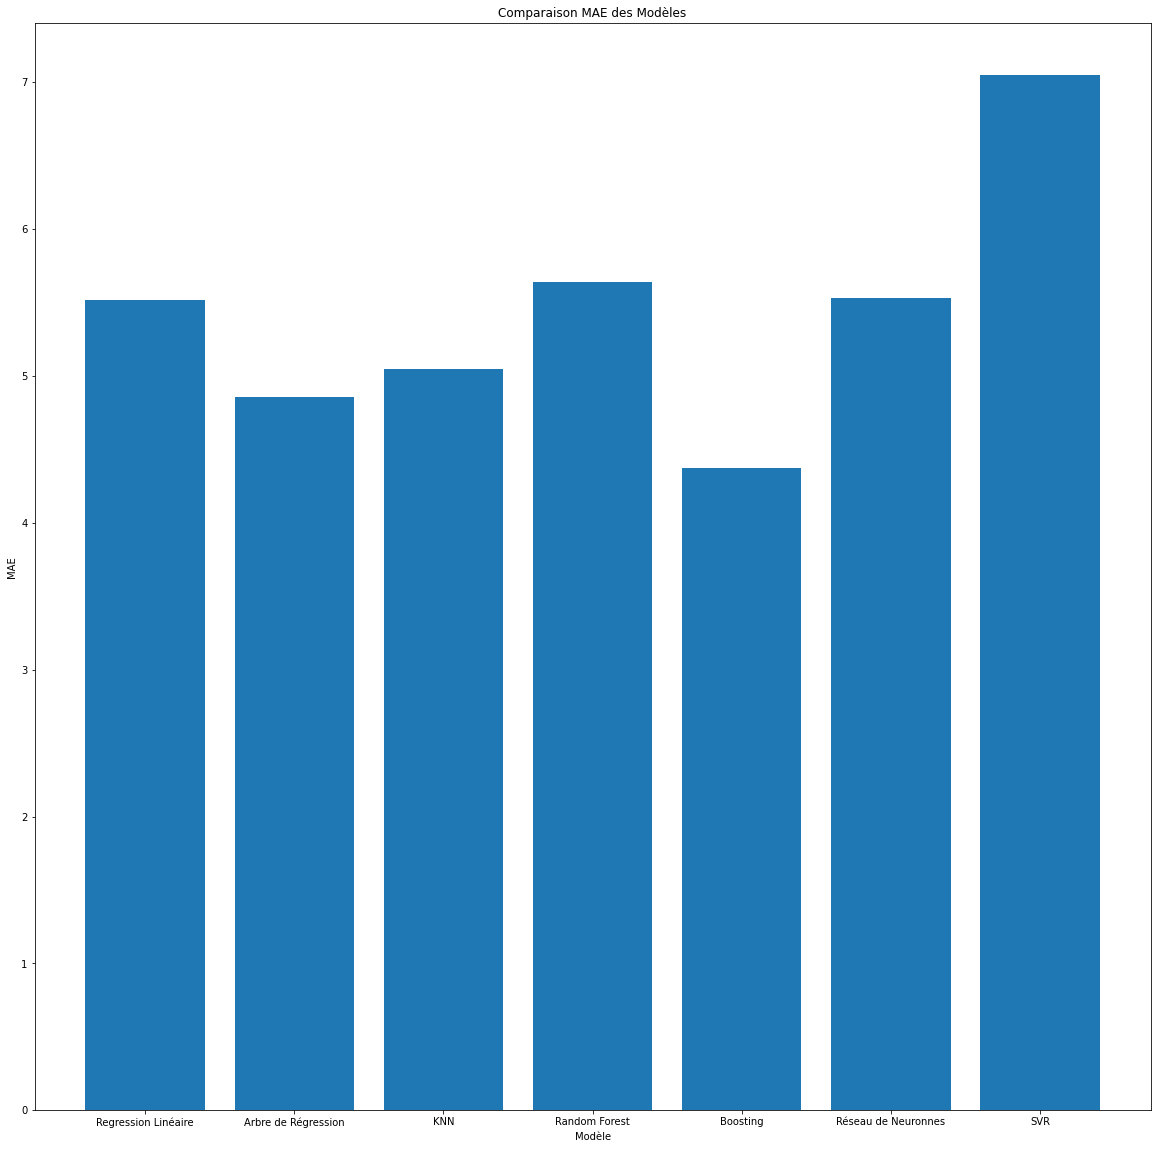

In [ ]:
plt.title("Comparaison MAE des Modèles")
plt.xlabel("Modèle")
plt.ylabel("MAE")
plt.bar(list_name,list_mae)
plt.rc('figure', figsize=[20, 20])

La **plupart des modèles ont une performance similaire**. Seul le SVR apparaît comme ayant une MAE significativement plus élevée que les autres (au dessus de 7 dans la plupart des simulations réalisées). 

Le modèle le plus **performant en terme de MAE est le boosting obtenu grâce à XGBoost**. Cependant, ce modèle est **très coûteux en termes de calcul**, il faudrait donc peut être **lui préférer un modèle prenant moins de temps à s’exécuter et ayant une performance comparable**. Ce modèle pourrait être celui de l’**arbre de régression**.

Quand on regarde la **moyenne de la colonne nbrMotInsulte, cette dernière est à 9, les modèles de régression que nous avons ici ne sont donc pas très performants.**

**ATTENTION** Nous avons essayer d'enlever les valeurs extrêmes et de relancer les calculs. Cela nous donnait des MAE bien meilleures, proches des 2 mais la moyenne de la colonne tombait à 3.5 environ. 

Les **prédictions n'étaient donc pas meilleures**. 

Notre analyse est disponible dans ce notebook annexe. Il n'est pas commenté mais les résultats et les fonctions utilisées sont explicites : 

https://colab.research.google.com/drive/1JjwbfmMkoYqOL-xW9VM6Jbk5QhJVIAPM?usp=sharing

**Nous avons tenté cela car lors de l'analyse statistique nous avions remarqué de nombreuses valeurs extrêmes qui auraient pu être éliminées.**

#**Définition de la toxicité**

Notre méthode est une sorte de **méthode de scoring** : on définit des critères, des seuils et on regarde si un élément apparient à une catégorie ou à une autre.

La toxicité a été définie à l'aide de **5 facteurs**. Le facteur principal est celui qui rapporte le plus de point : le **nombre d'insultes** repérées dans les commentaires. Il rapporte **1 point**. 

**Les mots allongés ou en majuscules sont souvent utilisés pour critiquer ou pour montrer son énervement**. Ils sont donc **potentiellement source de toxicité**. Ils sont d'ailleurs fortement corrélés à notre variable principale (voir matrice de corrélation). Cependant, ils sont **moins déterminants**, pour nous, que le nomnbre d'insultes dans la définition de la toxicité. Ainsi, ils n'obtiennent pas un score de 1 mais de **0.75**. 

Les **facteurs à 0,5 sont des facteurs très corrélés au facteur principal mais qui ne sont pas nécessairement source de toxicité**. Par exemple, dans un débat sain, il peut tout à fait il y avoir beaucoup de questions et donc beaucoup de points d'interrogations. Idem pour les points d'exclamation. 

**Pour effectuer les comparaisons et attribuer les points, nous utilisons des ratios**. Nous comparons les nbrXMoyenne avec le ratio global. Par exemple, nous comparons le nbrMotInsulteMoyenne d'une vidéo avec le ratio total sum(df.nbrMotInsultes)/sum(df.message_count). Pour obtenir les points, il faut avoir un ratio supérieur au ratio global. 

**Le total est sur 3,5. Il faut qu'une vidéo ait plus de 1,75/3,5 pour être considéré comme toxique.** 

Il n'y aura que **2 catégories** à prévoir, toxique ou non toxique. Nous avons fait le choix de ne pas avoir **plus de catégories** pour éviter d'avoir une **catégorie trop petite**, ce qui rendrait la **prévision extrêmement difficile et peu pertinente**. 

In [ ]:
comp_1 = sum(df_youtube.nbrMotInsulte)/sum(df_youtube.message_count)
comp_2 = sum(df_youtube.nbrMotAllong)/sum(df_youtube.message_count)
comp_3 = sum(df_youtube.nbrMotMAJ)/sum(df_youtube.message_count)
comp_4 = sum(df_youtube.nbrExclMark)/sum(df_youtube.message_count)
comp_5 = sum(df_youtube.nbrQuestMark)/sum(df_youtube.message_count)

def facteur1(df):
    result = 0
    if df.nbrMotInsulteMoyenne >= comp_1:
        result = 1
    return result 

def facteur2(df):
    result = 0
    if df.nbrMotAllongMoyenne >= comp_2:
        result = 0.75
    return result 

def facteur3(df):
    result = 0
    if df.nbrMotMAJMoyenne >= comp_3:
        result = 0.75
    return result 

def facteur4(df):
    result = 0
    if df.nbrExclMarkMoyenne >= comp_4:
        result = 0.5
    return result 

def facteur5(df):
    result = 0
    if df.nbrQuestMarkMoyenne >= comp_5:
        result = 0.5
    return result 

def sum_factor(df):
    result = df.Factor_1+df.Factor_2+df.Factor_3+df.Factor_4+df.Factor_5
    return result

def toxicite(df):
    if df.Somme_Facteur <= 1.75 :
        # Pas toxique
        result = 0
    else :
        # Toxique
        result = 1
    return result 

df_youtube["Factor_1"]=df_youtube.apply(lambda row: facteur1(row),axis =1)
df_youtube["Factor_2"]=df_youtube.apply(lambda row: facteur2(row), axis =1)
df_youtube["Factor_3"]=df_youtube.apply(lambda row: facteur3(row), axis = 1)
df_youtube["Factor_4"]=df_youtube.apply(lambda row: facteur4(row), axis = 1)
df_youtube["Factor_5"]=df_youtube.apply(lambda row: facteur5(row), axis = 1)
df_youtube["Somme_Facteur"]=df_youtube.apply(lambda row: sum_factor(row), axis = 1)
df_youtube["Toxicite"]=df_youtube.apply(lambda row: toxicite(row), axis = 1)
df_youtube = df_youtube.drop(["Factor_1","Factor_2","Factor_3","Factor_4","Factor_5","Somme_Facteur"], axis =1)
df_youtube

,video_id_court,video_id,channel_id,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,channel_name,subscriberCount,viewCount,categorie_new,categ_inst,Toxicite
0,Uvvsvw_wxOs,VVU5R0d6QWhodmhKTzFoTDEwLUJjZ05BLlV2dnN2d193eE9z,UC9GGzAhhvhJO1hL10-BcgNA,3813,18,4,145,79,60,30.261900,0.142857,0.031746,1.150794,0.626984,0.476191,45,81,126,28,58,47,23,LeHuffPost,339922,225393312,Core,Pure Players,0
1,mCy1ZBdttwA,VVVYS0pyWWN6WTJfZkpFWmdGUEdZMEhRLm1DeTFaQmR0dHdB,UCXKJrYczY2_fJEZgFPGY0HQ,28,2,0,1,0,0,9.333333,0.666667,0.000000,0.333333,0.000000,0.000000,3,0,3,0,3,1,0,CNEWS,189971,132125693,Core,TV,0
2,iU3MyHMK5nU,VVU5R0d6QWhodmhKTzFoTDEwLUJjZ05BLmlVM015SE1LNW5V,UC9GGzAhhvhJO1hL10-BcgNA,3804,68,9,56,75,54,27.565220,0.492754,0.065217,0.405797,0.543478,0.391304,52,86,138,22,83,49,36,LeHuffPost,339922,225393312,Core,Pure Players,1
3,ZUim3AeURtk,VVViWjBDc3I5b3c2WGprZGQ1NDJPbWh3LlpVaW0zQWVVUnRr,UCbZ0Csr9ow6Xjkdd542Omhw,4,0,1,2,0,0,2.000000,0.000000,0.500000,1.000000,0.000000,0.000000,2,0,2,0,2,0,0,Telegramme,2862,2481100,Niche,Presse_regionale,0
4,n5Tg2vhLCAM,VVVoWldzNlBKWTBoTkQzODRkMl9ScmhRLm41VGcydmhMQ0FN,UChZWs6PJY0hND384d2_RrhQ,737,3,1,18,5,6,32.043478,0.130435,0.043478,0.782609,0.217391,0.260870,17,6,23,4,18,7,7,Les Echos,30010,6710737,Core,Presse nationale,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46097,0s_hwJrt_6E,VVVmSG5fOC1laGRlbTg2ZkV2bEZnLUd3LjBzX2h3SnJ0XzZF,UCfHn_8-ehdem86fEvlFg-Gw,16,0,0,0,3,0,5.333333,0.000000,0.000000,0.000000,1.000000,0.000000,3,0,3,0,3,1,0,Le Parisien,149018,85536183,Core,Presse_regionale,0
46098,ktsFSiFN1VY,VVVZcFJEbmhrNUg4aDE2anBTODR1cXNBLmt0c0ZTaUZOMVZZ,UCYpRDnhk5H8h16jpS84uqsA,228,1,1,0,0,1,228.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1,0,1,0,1,0,0,Le Monde,568615,134570352,Core,Presse nationale,1
46099,#NOM?,VVVYS0pyWWN6WTJfZkpFWmdGUEdZMEhRLi1abDVDaUtkZkFz,UCXKJrYczY2_fJEZgFPGY0HQ,287,2,0,3,2,0,35.875000,0.250000,0.000000,0.375000,0.250000,0.000000,8,0,8,0,7,5,3,CNEWS,189971,132125693,Core,TV,0
46100,CyHXcpFlrTg,VVVDRHpfWFllS1dkME9JeWpwOTVkcXlRLkN5SFhjcEZsclRn,UCCDz_XYeKWd0OIyjp95dqyQ,176,0,0,0,6,3,58.666670,0.000000,0.000000,0.000000,2.000000,1.000000,2,1,3,1,3,0,1,Le Figaro,180173,140135417,Core,Presse nationale,0


In [ ]:
print("Environ",int(len(df_youtube[df_youtube["Toxicite"]==1].index)/len(df_youtube.index)*100)+1, "% des vidéos sont considérées comme toxiques.")

Environ 16 % des vidéos sont considérées comme toxiques.


#**Classification**

Nous allons maintenant chercher à prédire l'appartenance d'une vidéo à une cétégorie de toxicité (1,2,3). 

Pour cela, nous allons utiliser **différents modèles**, nous allons chercher à les optimiser avec GridSearchCV et nous utiliserons le **f1-score, la courbe ROC** pour comparer les différents modèles. 

#### **Encodage des variables**

In [ ]:
# Suppression des variables inutiles 
df_classification = df_youtube.copy()
df_classification = df_classification.drop(['video_id_court','video_id','channel_id'], axis = 1)
df_classification

,nbrMot,nbrMotInsulte,nbrMotAllong,nbrMotMAJ,nbrExclMark,nbrQuestMark,nbrMotMoyenne,nbrMotInsulteMoyenne,nbrMotAllongMoyenne,nbrMotMAJMoyenne,nbrExclMarkMoyenne,nbrQuestMarkMoyenne,thread_count,comment_count,message_count,discussion_count,distinct_authors_count,authors_3channels_count,liked_authors_count,channel_name,subscriberCount,viewCount,categorie_new,categ_inst,Toxicite
0,3813,18,4,145,79,60,30.261900,0.142857,0.031746,1.150794,0.626984,0.476191,45,81,126,28,58,47,23,LeHuffPost,339922,225393312,Core,Pure Players,0
1,28,2,0,1,0,0,9.333333,0.666667,0.000000,0.333333,0.000000,0.000000,3,0,3,0,3,1,0,CNEWS,189971,132125693,Core,TV,0
2,3804,68,9,56,75,54,27.565220,0.492754,0.065217,0.405797,0.543478,0.391304,52,86,138,22,83,49,36,LeHuffPost,339922,225393312,Core,Pure Players,1
3,4,0,1,2,0,0,2.000000,0.000000,0.500000,1.000000,0.000000,0.000000,2,0,2,0,2,0,0,Telegramme,2862,2481100,Niche,Presse_regionale,0
4,737,3,1,18,5,6,32.043478,0.130435,0.043478,0.782609,0.217391,0.260870,17,6,23,4,18,7,7,Les Echos,30010,6710737,Core,Presse nationale,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46097,16,0,0,0,3,0,5.333333,0.000000,0.000000,0.000000,1.000000,0.000000,3,0,3,0,3,1,0,Le Parisien,149018,85536183,Core,Presse_regionale,0
46098,228,1,1,0,0,1,228.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1,0,1,0,1,0,0,Le Monde,568615,134570352,Core,Presse nationale,1
46099,287,2,0,3,2,0,35.875000,0.250000,0.000000,0.375000,0.250000,0.000000,8,0,8,0,7,5,3,CNEWS,189971,132125693,Core,TV,0
46100,176,0,0,0,6,3,58.666670,0.000000,0.000000,0.000000,2.000000,1.000000,2,1,3,1,3,0,1,Le Figaro,180173,140135417,Core,Presse nationale,0


In [ ]:
# Encodage
labelencoder = LabelEncoder()
df_classification['channel_name']=labelencoder.fit_transform(df_classification['channel_name'])
df_classification['categorie_new']=labelencoder.fit_transform(df_classification['categorie_new'])
df_classification['categ_inst']=labelencoder.fit_transform(df_classification['categ_inst'])

#### **Train/Test Split**

Commençons par séparer les variables en un **jeu de train et en un autre de test**. 

Par la même occasion, nous **standardiserons aussi nos jeux de données**. 

In [ ]:
# Split Train/Test et affichons, pour contrôle, le split
classification_feature = df_classification.drop(["Toxicite"],axis=1)
classification_result = df_classification["Toxicite"]

X,y = classification_feature, classification_result
X_trainC, X_testC, y_trainC, y_testC = train_test_split(X, y, test_size=1/3)
print(X_trainC.shape, X_testC.shape, y_trainC.shape, y_testC.shape)

(30734, 24) (15368, 24) (30734,) (15368,)


In [ ]:
# Standardisons
stds = preprocessing.StandardScaler()
Z_trainC = stds.fit_transform(X_trainC)
Z_testC = stds.fit_transform(X_testC)

#### **Réduction du nombre de features à l'aide d'un autoencodeur**

Une première idée que l'on peut avoir est de réduire le nombre de variables décrivant le système. En effet, il est possible que certains classifieurs aient de meilleures performances lorsqu'on leur fournit un nombre réduit de features.

Or, les réseaux de neurones sont adaptés pour décrire les données en aggrégeant les features de bases. C'est ce résultat que nous tentons d'obtenir ici en nous aidant d'une architecture de type autoencodeur.

Le réseau est entraîné de sorte à reproduire l'input en sortie, en passant par des couches de taille réduite. De cette façon, nous nous assurons que le réseau est capable de faire une description de la donnée avec moins de features, puis de la reconstruire à partir de cette description. Nous tentons ici une décomposition en 4 features.

##### *Modèle  :*

In [ ]:
class Autoencoder(Model):
    
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.input_layer = Flatten()
        self.enc1 = Dense(8, activation='elu')
        self.encF = Dense(4, activation='elu') #Couche bottleneck : le nombre de neurones sur cette couche indique le nombre de features de décomposition.
        self.dec1 = Dense(2, activation='tanh')
        self.decF = Dense(1, activation='linear')
        self.output_layer = Reshape((1,))
    
    def call(self,x):
        x = self.input_layer(x)
        x = self.enc1(x)
        encoded_features = self.encF(x)
        decoded = self.decF(encoded_features)
        decoded = self.output_layer(decoded)
        return(decoded,encoded_features)
    
    def decode(self,enc):
        decoded = self.decF(encoded_features)
        decoded = self.output_layer(decoded)
        return(decoded)
    
@tf.function
def train_step(X):
    with tf.GradientTape() as tape:
        predictions, encoded_features = model(X, training=True)
        loss_step = loss(X, predictions)
    gradients = tape.gradient(loss_step, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss_step)
    train_mae(X, predictions)

@tf.function
def test_step(X):
    predictions, encoded_features = model(X, training=False)
    loss_test = loss(X, predictions)
    
    test_loss(loss_test)
    test_mae(X, predictions)

@tf.function
def predict(X):
    predictions, encoded_features = model(X, training=False)
    return(predictions, encoded_features)

Le réseau est entraîné sur 5 epochs, en utilisant le dataset train à la fois comme input et comme label.

In [ ]:
epochs = 5
model = Autoencoder()
loss = tf.keras.losses.MeanSquaredError()
optimizer = Adam(learning_rate=0.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanSquaredError(name='train_mae')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mae = tf.keras.metrics.MeanSquaredError(name='test_mae')

In [ ]:
for epoch in range(epochs):
        
    train_loss.reset_states()
    train_mae.reset_states()
    test_loss.reset_states()
    test_mae.reset_states()
        
    for Xtr in Z_trainC:
        train_step(Xtr)
    for Xtst in Z_testC:
        test_step(Xtst)
        
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'MAE: {train_mae.result()}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test MAE: {test_mae.result()}'
        )


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.00540181715041399, MAE: 0.00540181715041399, Test Loss: 1.9273304133093916e-05, Test MAE: 1.9273304133093916e-05
Epoch 2, Loss: 0.0013487179530784488, MAE: 0.0013487179530784488, Test Loss: 5.867297204531496e-06, Test MAE: 5.867297204531496e-06
Epoch 3, Loss: 0.0016097879270091653, MAE: 0.0016097879270091653, Test Loss: 4.095637268619612e-05, Test MAE: 4.095637268619612e-05
Epoch 4, Loss: 0.0006972322007641196, MAE: 0.0006972322007641196, Test Loss: 4.956575503456406e-05, Test MAE: 4.95

On obtient d'excellents résultats : le réseau est donc capable de reproduire à la quasi-perfection son input.

On peut donc construire un dataset composé des features réduites issues de la couche centrale du réseau.

In [ ]:
df_reduced_train = pd.DataFrame(index=range(len(Z_trainC)),columns=['Feature1','Feature2','Feature3','Feature4'])
df_reduced_test = pd.DataFrame(index=range(len(Z_testC)),columns=['Feature1','Feature2','Feature3','Feature4'])
for i in range(len(Z_trainC)):
  x_reduction = Z_trainC[i]
  prediction, reduced_features = predict(x_reduction)
  #La couche centrale retourne autant de décompositions que le nombre de features initiales.
  #Cependant, ces décompositions donnent toutes le même résultat une fois décodées, et sont donc équivalentes.
  reduction = random.choice(reduced_features)
  df_reduced_train.iloc[i] = reduction
for i in range(len(Z_testC)):
  x_reduction = Z_testC[i]
  prediction, reduced_features = predict(x_reduction)
  reduction = random.choice(reduced_features)
  df_reduced_test.iloc[i] = reduction

       Feature1  Feature2   Feature3  ... Feature14 Feature15 Feature16
0     -0.739562 -0.712504  -0.100752  ...  0.303514  0.194904  0.918769
1     -0.784641 -0.814835 -0.0835958  ...  0.590251  0.156311   1.49479
2     -0.789093 -0.823889   -0.08544  ...  0.625862  0.156894   1.56276
3     -0.748236 -0.733145 -0.0922488  ...  0.348425   0.17838   1.01468
4     -0.791849 -0.829376 -0.0868793  ...   0.64861  0.157512   1.60595
...         ...       ...        ...  ...       ...       ...       ...
30729 -0.804231 -0.852928 -0.0963781  ...  0.758002  0.162958   1.81133
30730 -0.745283 -0.726183 -0.0949369  ...  0.332752  0.183588  0.981413
30731 -0.788075 -0.821838 -0.0849665  ...  0.617594  0.156716   1.54702
30732 -0.792585 -0.830826 -0.0873032  ...  0.654776  0.157712   1.61763
30733  -0.72629 -0.679928  -0.117388  ...   0.24154  0.227915  0.782719

[30734 rows x 16 columns]
       Feature1  Feature2   Feature3  ... Feature14 Feature15 Feature16
0      -0.77352 -0.791205 -0.0813953 

##### *Evaluation de l'utilité du modèle  :*

Nous avons **effectué différents modèles pour évaluer la pertinence de cet auto-encodeur. Tous les résultats obtenus étaient similaires**. Par conséquence, nous en avons **laissé un uniquement, pour exemple**.


**Arbre de décision :**

##### *Sélection des meilleurs paramètres :*

In [ ]:
parameters = {
    "max_depth": range(2,20),
    "min_samples_leaf": range(1,15),
}

model_desicion_tree = tree.DecisionTreeClassifier(criterion = 'gini',random_state=42)
model_desicion_tree = GridSearchCV(
    model_desicion_tree, 
    parameters, 
    cv=5,
    scoring='f1',
)

model_desicion_tree.fit(df_reduced_train, y_trainC)
print('-----')
print(f'Best parameter {model_desicion_tree.best_params_}')
print('-----')

-----
Best parameter {'max_depth': 19, 'min_samples_leaf': 13}
-----


##### *Entrainement du modèle :*

In [ ]:
tree_youtube_C = model_desicion_tree.best_estimator_
tree_youtube_C = tree_youtube_C.fit(df_reduced_train, y_trainC)

##### *Test* :

In [ ]:
y_pred_treeC = tree_youtube_C.predict(df_reduced_test)

##### *Evaluation* :

In [ ]:
print(metrics.classification_report(y_testC,y_pred_treeC))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89     12926
           1       0.26      0.12      0.16      2442

    accuracy                           0.81     15368
   macro avg       0.55      0.53      0.53     15368
weighted avg       0.75      0.81      0.77     15368



##### *Conclusion* :

Le **f1-score pour les vidéos toxiques est très mauvais**. On ne repère pas suffisament les vidéos repérées comme toxiques malgré la puissance de l'autoencodeur. 

Nous avons aussi **essayer d'augmenter le nombre de features en sortie de l'auto encodeur** (8 puis 16 features), cela n'a pas amélioré les résultats. 

De fait, **nous allons proposer un nouveau modèle qui ne sera pas fondé sur ce réseau de neurones**. 

#### **Train-Test Split sans Réseau de Neurones**

##### *Suppression des features inutiles* 

In [ ]:
# Afin d'augmenter la robustesse, nous supprimons les nbrXMoyenne ainsi que les message_count permettant de retrouver
# rapidement ces ratios là. 
df_classification_2 = df_youtube.copy()
df_classification_2 = df_classification_2.drop(["video_id_court","video_id","nbrMotMoyenne","nbrMotInsulteMoyenne","nbrMotAllongMoyenne","nbrMotMAJMoyenne","nbrExclMarkMoyenne","nbrQuestMarkMoyenne","message_count",'channel_id'],axis = 1)

##### *Encodage des variables*

In [ ]:
labelencoder = LabelEncoder()
df_classification_2['channel_name']=labelencoder.fit_transform(df_classification_2['channel_name'])
df_classification_2['categorie_new']=labelencoder.fit_transform(df_classification_2['categorie_new'])
df_classification_2['categ_inst']=labelencoder.fit_transform(df_classification_2['categ_inst'])

##### *Train-Test Split*

In [ ]:
classification_feature2 = df_classification_2.drop(["Toxicite"],axis=1)
classification_result2 = df_classification_2["Toxicite"]

X,y = classification_feature2, classification_result2
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=1/3)
print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

(30734, 17) (15368, 17) (30734,) (15368,)


In [ ]:
# Standardisation 
stds = preprocessing.StandardScaler()
Z_train2 = stds.fit_transform(X_train2)
Z_test2 = stds.fit_transform(X_test2)

Maintenant, nous allons utiliser ce **nouveau modèle pour classer**. 

#### **Arbre de décision**

##### *Sélection des meilleurs paramètres :*

In [ ]:
parameters = {
    "max_depth": range(2,20),
    "min_samples_leaf": range(1,15),
}

model_desicion_tree = tree.DecisionTreeClassifier(criterion = 'gini',random_state=42)
model_desicion_tree = GridSearchCV(
    model_desicion_tree, 
    parameters, 
    cv=5,
    scoring='f1',
)

model_desicion_tree.fit(X_train2, y_train2)
print('-----')
print(f'Best parameter {model_desicion_tree.best_params_}')
print('-----')

-----
Best parameter {'max_depth': 14, 'min_samples_leaf': 5}
-----


##### *Entrainement du modèle :*

In [ ]:
tree_class_youtube = model_desicion_tree.best_estimator_
tree_class_youtube = tree_class_youtube.fit(X_train2, y_train2)

##### *Test :*

In [ ]:
y_pred_tree_class = tree_class_youtube.predict(X_test2)

##### *Evaluation du modèle :*

In [ ]:
print(metrics.classification_report(y_test2,y_pred_tree_class))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     13011
           1       0.78      0.76      0.77      2357

    accuracy                           0.93     15368
   macro avg       0.87      0.86      0.86     15368
weighted avg       0.93      0.93      0.93     15368



##### *Conclusion :*

Nous obtenons un **bon f1-score pour la classe toxique (classe 1)**. Ce résultat de prédiction est bien meilleur que celui obtenu avec le dataframe de l'autoencodeur. La **prévision de la classe non toxique est aussi meilleure**. 

#### **Random Forest**

##### *Sélection des meilleurs paramètres :*

In [ ]:
parameters = {
    "max_depth": range(2,20),
}

model_desicion_rf = RandomForestClassifier(random_state=42)
model_desicion_rf = GridSearchCV(
    model_desicion_rf, 
    parameters, 
    cv=5,
    scoring='f1',
)

model_desicion_rf.fit(X_train2, y_train2)
print('-----')
print(f'Best parameter {model_desicion_rf.best_params_}')
print('-----')

-----
Best parameter {'max_depth': 16}
-----


##### *Entrainement du modèle :*

In [ ]:
rf_youtube_C = model_desicion_rf.best_estimator_
rf_youtube_C = rf_youtube_C.fit(X_train2, y_train2)

##### *Test :*

In [ ]:
y_pred_rf_C = rf_youtube_C.predict(X_test2)

##### *Evaluation :*

In [ ]:
print(metrics.classification_report(y_test2,y_pred_rf_C))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     13011
           1       0.90      0.79      0.84      2357

    accuracy                           0.95     15368
   macro avg       0.93      0.89      0.91     15368
weighted avg       0.95      0.95      0.95     15368



##### *Conclusion :*

**Pour un temps de calcul à peu près équivalent à celui de l'arbre, la forêt aléatoire fournit un résultat meilleur**.Le classifieur ne se trompe quasiment jamais sur les vidéos non toxiques et réussit très bien à classer les vidéos toxiques. 

**Le f1-score pour les vidéos toxiques est bon** : supérieure à 0.8 à chaque itération. 

#### **KNN Classification**

##### *Sélection des meilleurs paramètres :*

In [ ]:
param_grid={'n_neighbors':range(1,20),
            'metric':['euclidean','manhattan'],
            "weights":['uniform','distance'],
}
model_classifier_KNN = KNeighborsClassifier()
model_classifier_KNN = GridSearchCV(
    model_classifier_KNN, 
    param_grid, 
    cv=5,
    scoring='neg_mean_absolute_error',
)

model_classifier_KNN.fit(X_train2, y_train2)
print('-----')
print(f'Best parameter {model_classifier_KNN.best_params_}')
print('-----')

-----
Best parameter {'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'}
-----


##### *Entrainement du modèle :*

In [ ]:
KNN_youtube_C = model_classifier_KNN.best_estimator_
KNN_youtube_C = KNN_youtube_C.fit(X_train2,y_train2)

##### *Test :*

In [ ]:
y_pred_KNN_C = KNN_youtube_C.predict(X_test2)

##### *Evaluation :*

In [ ]:
print(metrics.classification_report(y_test2,y_pred_KNN_C))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     13011
           1       0.67      0.27      0.39      2357

    accuracy                           0.87     15368
   macro avg       0.78      0.62      0.66     15368
weighted avg       0.85      0.87      0.84     15368



##### *Conclusion :*

Ce modèle estpour l'instant le moins bon des modèles de classification. **Le f1-score est presque deux fois inférieur par rapport à celui obtenu avec la forêt aléatoire**. Ce modèle ne sera pas retenu. 

#### **Gradient Boosting**

##### *Sélection des meilleurs paramètres :*

In [ ]:
parameters = {
    "max_depth": range(2,20),
    "learning_rate":[0.01,0.1,0.05]
}

model_xgb_C = xgb.XGBClassifier(objective="reg:squarederror",booster='gbtree')
model_xgb_C = GridSearchCV(
    model_xgb_C, 
    parameters, 
    cv=5,
    scoring='neg_mean_absolute_error',
)

model_xgb_C.fit(X_train2, y_train2)
print('-----')
print(f'Best parameter {model_xgb_C.best_params_}')
print('-----')

-----
Best parameter {'learning_rate': 0.1, 'max_depth': 9}
-----


##### *Entrainement du modèle :*

In [ ]:
xgbr_C = model_xgb_C.best_estimator_
xgbr_C = xgbr_C.fit(X_train2, y_train2)

##### *Test :*

In [ ]:
y_pred_xgbr_C = xgbr_C.predict(X_test2)

##### *Evaluation :*

In [ ]:
print(metrics.classification_report(y_test2,y_pred_xgbr_C))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     13011
           1       0.90      0.85      0.88      2357

    accuracy                           0.96     15368
   macro avg       0.94      0.92      0.93     15368
weighted avg       0.96      0.96      0.96     15368



##### *Conclusion :*

Le Gradient Boosting avec **XGBoost donne un résultat sensiblement meilleur que la forêt aléatoire**. Cependant, ce modèle a un **temps de calcul colossal**.

Le f1-score sur la classe vidéos toxiques restent cependant très bon. 

#### **Réseau de neurones**

On utilise cette fois-ci un modèle adapté à la classification : il y a deux neurones de sortie, chacun représentant une classe. Après conversion via un softmax, on obtient la probabilité d'être dans une classe ou l'autre.

##### *Création du modèle :*

In [ ]:
class classificationNN(Model):
    
    def __init__(self):
        super(classificationNN, self).__init__()
        self.input_layer = InputLayer()
        self.f = Flatten()
        self.d0 = Dense(128, activation='tanh')
        self.output_layer = Dense(2, activation='linear')
        self.to_prob = Softmax()
    
    def call(self,x):
        x = self.input_layer(x)
        x = self.f(x)
        x = self.d0(x)
        xpred = self.output_layer(x)
        xprob = self.to_prob(xpred)
        return(xpred,xprob)

##### *Prédiction:*

In [ ]:
model = classificationNN()
optimizerC = SGD(learning_rate=0.01)
lossC = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizerC,loss=lossC, metrics=['accuracy'])
model.fit(X_train2,y_train2,epochs=5)
print('Test results\n')
print(model.evaluate(X_test2,y_test2,verbose=2))

Epoch 1/5
961/961 [==============================] - 1s 1000us/step - loss: 0.9546 - output_1_loss: 0.4483 - output_2_loss: 0.5063 - output_1_accuracy: 0.8407 - output_2_accuracy: 0.8407
Epoch 2/5
961/961 [==============================] - 1s 997us/step - loss: 0.9544 - output_1_loss: 0.4481 - output_2_loss: 0.5063 - output_1_accuracy: 0.8407 - output_2_accuracy: 0.8407
Epoch 3/5
961/961 [==============================] - 1s 984us/step - loss: 0.9555 - output_1_loss: 0.4490 - output_2_loss: 0.5065 - output_1_accuracy: 0.8407 - output_2_accuracy: 0.8407
Epoch 4/5
961/961 [==============================] - 1s 970us/step - loss: 0.9550 - output_1_loss: 0.4486 - output_2_loss: 0.5064 - output_1_accuracy: 0.8407 - output_2_accuracy: 0.8407
Epoch 5/5
961/961 [==============================] - 1s 992us/step - loss: 0.9544 - output_1_loss: 0.4480 - output_2_loss: 0.5063 - output_1_accuracy: 0.8407 - output_2_accuracy: 0.8407
Test results

481/481 - 0s - loss: 0.9341 - output_1_loss: 0.4367 - o

L'accuracy semble élevée, mais il s'agit d'une illusion.

In [ ]:
predictions = model.predict(X_test2)
pred_labels = [np.argmax(prediction) for prediction in predictions[1]]
print(metrics.classification_report(y_test2,pred_labels))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     13011
           1       0.00      0.00      0.00      2357

    accuracy                           0.85     15368
   macro avg       0.42      0.50      0.46     15368
weighted avg       0.72      0.85      0.78     15368



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


En effet, **le réseau est inefficace est prédit sans discriminer que les données appartiennent à une classe ou à l'autre** (selon les paramètres d'entrée).

Ici, son accuracy élevée est due uniquement au fait qu'il peut correctement prédire 100% de la classe 0, et 0% de la classe 1!

##### *Conclusion :*

Le **réseau de neurones, tel qu'il a été construit, comporte des défaillances structurelles évidentes. Il devrait être modifié si l'on souhaite l'utiliser pour cette prédiction.**

#### SVM classification

Nous allons commencer par faire tourner le modèle une première fois avec les paramètres par défaut. Il est intéressant de constater que le modèle classe tout dans la même catégorie.

In [ ]:
model = SVC() 
model.fit(X_train2, y_train2) 
  
# print prediction results 
predictions = model.predict(X_test2) 
print(classification_report(y_test2, predictions)) 

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     13011
           1       0.00      0.00      0.00      2357

    accuracy                           0.85     15368
   macro avg       0.42      0.50      0.46     15368
weighted avg       0.72      0.85      0.78     15368



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Selection des meilleurs paramètres.

Pour régler ce problème, nous devons sélectionner les meilleurs paramètres du modèle. Nous allons donc utiliser Grid search pour cela.

ATTENTION : Le code peut être très long à faire tourner. Il est possible de changer le type de noyau et les valeurs de C et gamma mais il daut compter une demi-heure une heure à chaque lancement du code

In [ ]:
param_grid = {'C': [ 1, 10, 100, 1000],  
              'gamma': [0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, scoring='f1', refit = True, verbose = 3, cv=2) 
  
# fitting the model for grid search 
grid.fit(X_train2, y_train2) 

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] C=1, gamma=0.01, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.029, total=  29.0s
[CV] C=1, gamma=0.01, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.0s remaining:    0.0s


[CV] ......... C=1, gamma=0.01, kernel=rbf, score=0.033, total=  25.3s
[CV] C=1, gamma=0.001, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.3s remaining:    0.0s


[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.112, total=  14.9s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.118, total=  12.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.198, total=   9.7s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.214, total=   9.5s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.159, total=  43.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.158, total=  41.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.264, total=  26.5s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  9.4min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=3)

Nous avons fait tourner l'algorithme avec des noyaux linéaire, rbf et polynomiaux. Seul le calcul sur le rbf a abouti les paramètres sélectionnés en sortie sont : C = 1000
Gamma = 0,0001
kernel = rbf

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_)

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


##### Entrainement du modèle

In [ ]:
model = SVC(C=1000, gamma=0.0001, kernel='rbf') 
model.fit(X_train2, y_train2) 

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

##### Test :

In [ ]:
svm_predictions = model.predict(X_test2) 

##### Evaluation

In [ ]:
print(classification_report(y_test2, svm_predictions)) 

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     13011
           1       0.62      0.37      0.47      2357

    accuracy                           0.87     15368
   macro avg       0.75      0.67      0.70     15368
weighted avg       0.85      0.87      0.85     15368



##### Conclusion :

Le **f1-score sur la classe des vidéos toxiques est globalement mauvais. Le temps de calcul est long voire très lon**. 

Nous ne recommandons pas d'utiliser ce modèle.

#### **Light GBM**

##### *Apport par rapport à XGBoost :*

**Performances comparables mais temps de calcul moindre. Il est aussi possible de choisir plusieurs types de boosting (4 au total)**. 

Ici, nous allons utiliser un autre type de boosting que celui utilisé par XGBoost, nous allons opter pour le boosting 'dart'. 

Une explication de ce modèle est disponible ici : 

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

##### *Sélection des meilleurs paramètres :*

In [ ]:
parameters = {
    'max_depth':range(2,20),
    'learning_rate':[0.01,0.1,0.05],
}

model_lgbm = lgb.LGBMClassifier(boosting_type = 'dart',
    random_state=42
)

model_lgbm = GridSearchCV(
    model_lgbm, 
    parameters, 
    cv=5,
    scoring='f1',
)

model_lgbm.fit(
    X_train2, 
    y_train2
)

print('-----')
print(f'Best parameters {model_lgbm.best_params_}')
print('-----')

-----
Best parameters {'learning_rate': 0.1, 'max_depth': 11}
-----


##### *Entrainement :*

In [ ]:
lgbm = model_lgbm.best_estimator_
lgbm = lgbm.fit(X_train2,y_train2)

##### *Test :*

In [ ]:
y_pred_lgbm = lgbm.predict(X_test2)

##### *Evaluation :*

In [ ]:
print(metrics.classification_report(y_test2,y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     13011
           1       0.91      0.79      0.84      2357

    accuracy                           0.96     15368
   macro avg       0.93      0.89      0.91     15368
weighted avg       0.95      0.96      0.95     15368



##### *Conclusion :*

**La performance est comparable à celle obtenue avec la Forêt Alétoire. Le temps de calcul n'est pas beaucoup plus long.** 

Le f1-score pour la classe 1 est bon. 

#### **Courbes ROC**

Nous allons **réaliser les courbes ROC des différents classifieurs**. 

Nous les comparerons entre elles afin de trouver le modèle le plus performant. 

Cependant, nous utiliserons aussi des notions de temps de calcul pour décider du ou des modèles qui seront les plus intéressants. 

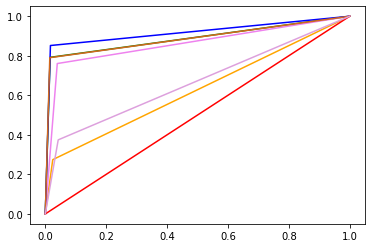

In [ ]:
rf_fpr, rf_tpr, thresholds = metrics.roc_curve(y_test2, y_pred_rf_C)
plt.plot(rf_fpr,rf_tpr, color = 'green')

knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_test2, y_pred_KNN_C)
plt.plot(knn_fpr,knn_tpr,color ='orange')

tree_fpr, tree_tpr, thresholds = metrics.roc_curve(y_test2, y_pred_tree_class)
plt.plot(tree_fpr,tree_tpr,color='violet')

xgb_fpr, xgb_tpr, thresholds = metrics.roc_curve(y_test2, y_pred_xgbr_C)
plt.plot(xgb_fpr,xgb_tpr,color = 'blue')

nn_fpr, nn_tpr, thresholds = metrics.roc_curve(y_test2, pred_labels)
plt.plot(nn_fpr,nn_tpr,color = 'red')

lgbm_fpr,lgbm_tpr, thresholds = metrics.roc_curve(y_test2, y_pred_lgbm)
plt.plot(lgbm_fpr,lgbm_tpr,color = 'chocolate')

svm_fpr,svm_tpr,thresholds = metrics.roc_curve(y_test2, svm_predictions)
plt.plot(svm_fpr,svm_tpr, color = 'plum')

#### **Conclusion Classification**

Nous pouvons conclure en disant que **le modèle possédant le meilleur f1-score est le XGBoost (Gradient Boosting)**. D'après la courbe ROC, il s'agit aussi du modèle le plus performant. 

Cependant, son **temps de calcul est très grand**. Il faudrait donc mieux se tourner vers des modèles aux performances comparables et avec un temps de calcul réduit. Ainsi, **la forêt aléatoire et le Light GBM apparaissent comme les modèles les plus pertinents. Ils allient à la fois performance et temps de calcul optimal**. 

#**Conclusion Générale**

L'**analyse statistique** qui a été menée en première partie nous a permis de faire émerger des comportements et qui ont été à la **base des hypothèses que nous avons formulé concernant la prédiction de la variable nbrMotInsulte**. 

Cette dernière a été **prédite avec plus ou moins de succès par différents modèles**. Il s'est avéré que le **Gradient Boosting** a été le **modèle le plus pertinent** pour prédire les valeurs de nbrMotInsulte. Cependant, des modèles comme la **forêt aléatoire ou les arbres de régression ont fait presque aussi bien avec un temps de calcul bien inférieur**. 

Après avoir **défini la toxicité à l'aide d'une méthode de scoring**, nous avons **cherché à prédire si une vidéo était toxique ou non**. Une nouvelle fois le gradient boosting a obtenu les meilleures performances au prix, une nouvelle fois, d'un temps de calcul énorme. Ainsi la **forêt aléatoire et le light boosting (Light GBM) apparaissent comme les alternatives les plus viables**. 

Nous avons **aussi tenté d'être innovant en proposant un auto-encodeur ou une suppression des valeurs jugées comme extrême. Cependant, ces deux tentatives n'ont pas abouti**. 

Nous avons aussi cherché à démontrer notre **goût pour la recherche en proposant des solutions d'optimisation et de prédiction qui n'avaient pas été présentées en cours** (GridSearchCV, Light GBM...). 